## Importing libraries and Environment Setup

In [0]:
!pip install tensorflow xgboost openpyxl pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/250.9 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 245.8/250.9 kB 13.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 6.8 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import pickle
import joblib
import zipfile
import re
import glob

import sklearn.pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import xgboost as xgb
from xgboost import XGBClassifier

from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

2025-05-07 17:17:32.537133: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 17:17:32.668958: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 17:17:32.790518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746638252.892964    1227 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746638252.920246    1227 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 17:17:33.153789: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [0]:
# Replace these with your actual values
storage_account_name = "wesaddata"
storage_account_key = ""
container_name = "wesad"
mount_point = f"/mnt/{container_name}"

# Mount Blob Storage (only if not already mounted)
if not any(mount.mountPoint == mount_point for mount in dbutils.fs.mounts()):
    dbutils.fs.mount(
        source = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/",
        mount_point = mount_point,
        extra_configs = {f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net": storage_account_key}
    )

excel_path = "/dbfs/mnt/wesad/resampledSensorData.xlsx"
data_path_redone = "/dbfs/mnt/wesad/Participants_Data_Combined.csv"
df = pd.read_excel(excel_path, engine= 'openpyxl')
dataframe = pd.read_csv(data_path_redone)


### Participant ETL pipeline

''' We Fetch the pkl file which contains the sensor data for wrist watch, chest sensors and stress labels.

''' We also fwetch questonaire filled in by partcipant indicating fi they feel streesed, ammused etc.

''' Fetching their metadata such as age, gender, height wt ..

''' Finally We compile resample all our sensors ata frequency of 40Hz. and add in the metadata.


In [0]:
def participant_pkl_data(subject_folder, subject):
    """
    takes: each participants data folder and subject tag

    returns: chest, wrist data and the labels for stress, no stress, amusement ...
    """
    with open(subject_folder+f"/{subject}.pkl", "rb") as f:
        obj = pickle.load(f, encoding="latin1")

    return obj['signal']['chest'], obj['signal']['wrist'], obj['label']

def participant_questionaire(subject_folder, subject):
    """
    takes: each participants data folder and subject tag

    returns: questionaire about stress filled in by the participant (used based on label availablity)
    """

    df = pd.read_csv(subject_folder+f"/{subject}_quest.csv")
    return df

def participant_info(subject_folder, subject):
    """
    takes: each participants data folder and subject tag

    returns: information such as age, gender, smoker, coffee drinker, atheletic etc
    """
    with open(subject_folder+f"/{subject}_readme.txt", "r") as file:
        data = file.readlines()

    parsed_data = {}

    patterns = {
        "Age": r"Age:\s*(\d+)",
        "Height": r"Height \(cm\):\s*(\d+)",
        "Weight": r"Weight \(kg\):\s*(\d+)",
        "Gender": r"Gender:\s*(\w+)",
        "Dominant Hand": r"Dominant hand:\s*(\w+)",
        "Drank Coffee Today": r"Did you drink coffee today\?\s*(\w+)",
        "Drank Coffee Last Hour": r"Did you drink coffee within the last hour\?\s*(\w+)",
        "Did Sports Today": r"Did you do any sports today\?\s*(\w+)",
        "Smoker": r"Are you a smoker\?\s*(\w+)",
        "Smoked Last Hour": r"Did you smoke within the last hour\?\s*(\w+)",
        "Feel Ill Today": r"Do you feel ill today\?\s*(\w+)"
    }

    for line in data:
        for key, pattern in patterns.items():
            match = re.search(pattern, line, re.IGNORECASE)
            if match:
                parsed_data[key] = match.group(1)

    return parsed_data

def resample_sensor_arrays(sensor_data, info, subject, target_freq = 40):
    frequencies = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'labels': 700}

    # Estimate target length using a reference sensor (here: EDA)
    reference_sensor = 'EDA'
    if reference_sensor not in sensor_data:
        raise ValueError(f"Reference sensor '{reference_sensor}' missing.")

    original_len = len(sensor_data[reference_sensor])
    ref_freq = frequencies[reference_sensor]
    target_length = int(original_len * (target_freq / ref_freq))

    time_indices = np.arange(target_length) / target_freq  # Consistent timeline across all sensors
    print(f"\nProcessing: {subject}...\nTarget Frequency : {target_freq}Hz")

    resampled_data = {}

    for sensor, data in sensor_data.items():
        if sensor not in frequencies:  # Skip unknown sensors
            print(f"Skipping unknown sensor: {sensor}")
            continue

        sensor_freq = frequencies[sensor]
        sensor_time = np.arange(len(data)) / sensor_freq  # Correct time indices

        try:
            if sensor == "ACC":
                for i, axis in enumerate(["x", "y", "z"]):
                    # Accept both np.ndarray or nested list input
                    axis_data = data[:, i] if isinstance(data, np.ndarray) else np.array([row[i] for row in data])

                    # Handle NaNs using interpolation + fill
                    axis_data = pd.Series(axis_data).interpolate(limit_direction='both') \
                                                     .bfill().ffill()

                    interp_func = interp1d(sensor_time, axis_data, kind='slinear', fill_value="extrapolate")
                    resampled_data[f"ACC_{axis}"] = interp_func(time_indices)

            else:
                flat_data = np.array(data).flatten()
                flat_data = pd.Series(flat_data).interpolate(limit_direction='both') \
                                                .bfill().ffill()

                interp_func = interp1d(sensor_time, flat_data, kind='linear', fill_value="extrapolate")
                resampled_data[sensor] = interp_func(time_indices)

        except Exception as e:
            print(f"[ERROR] Sensor '{sensor}': {e}")

    for i, j in resampled_data.items():
        print(f"{i} : {len(j)}")
    print(f"{subject} Resampled\n")

    # ✅ Final DataFrame with interpolated sensor data
    resampled_df = pd.DataFrame(resampled_data, index=time_indices)
    resampled_df.index.name = "Time (s)"

    # ✅ Append metadata and subject info
    for key, val in info.items():
        resampled_df[key] = val
    resampled_df['Subject'] = subject

    return resampled_df


## Helper variables, Environment Setup and additional reuseable functionalities

In [0]:
# Defineing helper variables
subject_data = {}

subjects_half1 = ['S2','S3','S4','S5','S6','S7','S8','S9']
subjects_half2= ['S10','S11','S13','S14','S15','S16','S17']
subjects = ['S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S13','S14','S15','S16','S17']
WESAD_data_files_path = '/content/drive/Shareddrives/MediCap/Project_files/WESAD/data/WESAD/'
sensors = ["Time (s)","ACC_x", "ACC_y", "ACC_z", "BVP", "EDA", "TEMP"]
metadata = ["Age", "Height", "Weight", "Gender", "Dominant Hand", "Did Sports Today","Smoker","Smoked Last Hour","Feel Ill Today"]

build_subjects = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15']
eval_subjects = ['S16', 'S17']

In [0]:
def add_combined_acc(df):
    df["ACC_magnitude"] = np.sqrt(df["ACC_x"]**2 + df["ACC_y"]**2 + df["ACC_z"]**2)
    return df

def plot_sensor_graph(df, features, time_col="Time (s)", group_col="Subject", label_col="labels"):
    label_colors = {
        0: '#DDDDDD',
        1: '#1f77b4',
        2: '#d62728',
        3: '#2ca02c',
        4: '#9467bd'
    }

    label_names = {
        0: "Neutral",
        1: "Baseline",
        2: "Stress",
        3: "Amusement",
        4: "Meditation"
    }

    subjects = df[group_col].unique()

    for subj in subjects:
        df_subj = add_combined_acc(df[df[group_col] == subj].sort_values(time_col))


        for feat in features:
            plt.figure(figsize=(12, 4))
            plt.plot(df_subj[time_col], df_subj[f"{feat}"], label=f"{feat} Sensor", color='blue', alpha=0.6)

            plt.axhline(y=df_subj[feat].median(), color='green', linestyle='--', label='Baseline')

            last_label = None
            start_time = None

            for i, row in df_subj.iterrows():
                current_label = row[label_col]
                current_time = row[time_col]
                if last_label is None:
                    last_label = current_label
                    start_time = current_time
                elif current_label != last_label:
                    plt.axvspan(start_time, current_time, color=label_colors.get(last_label, '#EEEEEE'), alpha=0.1)
                    start_time = current_time
                    last_label = current_label
            plt.axvspan(start_time, df_subj[time_col].iloc[-1], color=label_colors.get(last_label, '#EEEEEE'), alpha=0.1)

            patches = [mpatches.Patch(color=color, label=label_names[l]) for l, color in label_colors.items()]
            plt.legend(handles=patches + plt.gca().get_legend_handles_labels()[0], loc='upper right')
            plt.title(f"Subject {subj} - {feat} with Emotion Overlay")
            plt.xlabel("Time (s)")
            plt.ylabel(feat)

        plt.tight_layout()
        plt.show()

def data_subsetting(df, subjects):
    subset = df[df['Subject'].isin(subjects)]
    return subset


## Creating Dataframe using Pipeline


In [0]:
for subject in subjects:
    subject_file_path = WESAD_data_files_path + subject
    _, wrist_dict, label = participant_pkl_data(subject_file_path, subject)
    info = participant_info(subject_file_path, subject)
    wrist_dict['labels'] = label

    subject_sensordata = resample_sensor_arrays(wrist_dict, info, subject)
    subject_sensordata.reset_index(inplace=True)
    subject_data[subject] = subject_sensordata

# subject_data
dataframe = pd.concat(list(subject_data.values()), axis=0, ignore_index=True)


To save dataframe will have to run this. but not running this for now.

In [0]:
dataframe

,Unnamed: 0,Time (s),ACC_x,ACC_y,ACC_z,BVP,EDA,TEMP,labels,Age,Height,Weight,Gender,Dominant Hand,Drank Coffee Today,Drank Coffee Last Hour,Did Sports Today,Smoker,Smoked Last Hour,Feel Ill Today,Subject
0,0,0.000,62.0,-21.0,107.0,-59.370,1.138257,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
1,1,0.025,65.2,6.2,63.8,-48.008,1.136976,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
2,2,0.050,51.0,10.6,30.2,-30.694,1.135694,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
3,3,0.075,45.4,11.8,18.6,-10.822,1.134413,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
4,4,0.100,52.4,15.8,26.0,7.580,1.133132,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474715,3474715,5919.875,-43.0,-44.0,-54.0,0.950,0.782691,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
3474716,3474716,5919.900,-39.0,-43.2,-85.2,-0.576,0.782563,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
3474717,3474717,5919.925,-14.0,-48.4,-100.2,-2.328,0.782435,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
3474718,3474718,5919.950,-50.0,3.2,-12.2,-4.200,0.782307,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17


In [0]:
df

,Unnamed: 0,Time (s),ACC_x,ACC_y,ACC_z,BVP,EDA,TEMP,labels,Age,Height,Weight,Gender,Dominant Hand,Drank Coffee Today,Drank Coffee Last Hour,Did Sports Today,Smoker,Smoked Last Hour,Feel Ill Today,Subject
0,0,0.00,62,-21,107,-59.37,1.138257,35.41,0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
1,1,0.25,51,16,35,43.50,1.125444,35.41,0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
2,2,0.50,53,21,-6,53.56,1.011405,35.41,0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
3,3,0.75,55,17,34,54.64,1.033188,35.41,0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
4,4,1.00,48,24,15,-117.88,0.935807,35.41,0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347467,347467,5918.75,-52,-38,-5,3.52,0.792287,31.81,0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
347468,347468,5919.00,-53,-37,-4,7.15,0.787170,31.81,0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
347469,347469,5919.25,-52,-38,-4,-4.62,0.787170,31.81,0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
347470,347470,5919.50,-52,-38,-4,4.99,0.784611,31.81,0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17


## Exploratory Data Analysis

In [0]:
dataframe.describe()

,Unnamed: 0,Time (s),ACC_x,ACC_y,ACC_z,BVP,EDA,TEMP,labels,Age,Height,Weight
count,347472.000000,347472.000000,347472.000000,347472.000000,347472.000000,347472.000000,347472.000000,347472.000000,347472.000000,347472.000000,347472.000000,347472.000000
mean,173735.500000,2920.918399,11.661924,-2.273458,17.708094,-0.010067,1.801780,32.598085,1.334726,27.497675,177.384330,73.181160
std,100306.670705,1717.376618,44.111446,28.148090,29.754107,65.301976,2.343278,1.498091,1.628351,2.425451,6.571889,9.932242
min,0.000000,0.000000,-128.000000,-128.000000,-128.000000,-1671.830000,0.045113,28.970000,0.000000,24.000000,165.000000,54.000000
25%,86867.750000,1447.750000,-36.000000,-19.000000,-2.000000,-14.930000,0.335976,31.550000,0.000000,26.000000,172.000000,66.000000
50%,173735.500000,2895.500000,26.000000,-1.000000,17.000000,2.160000,0.830669,32.710000,1.000000,27.000000,178.000000,75.000000
75%,260603.250000,4343.250000,51.000000,12.000000,43.000000,16.240000,2.396028,33.680000,2.000000,28.000000,184.000000,80.000000
max,347471.000000,7070.750000,127.000000,127.000000,127.000000,1409.940000,15.921474,35.970000,7.000000,35.000000,189.000000,90.000000


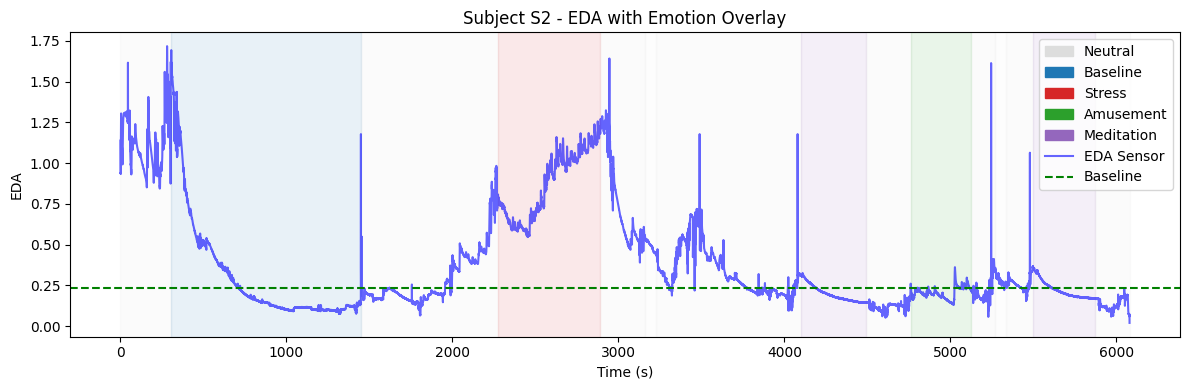

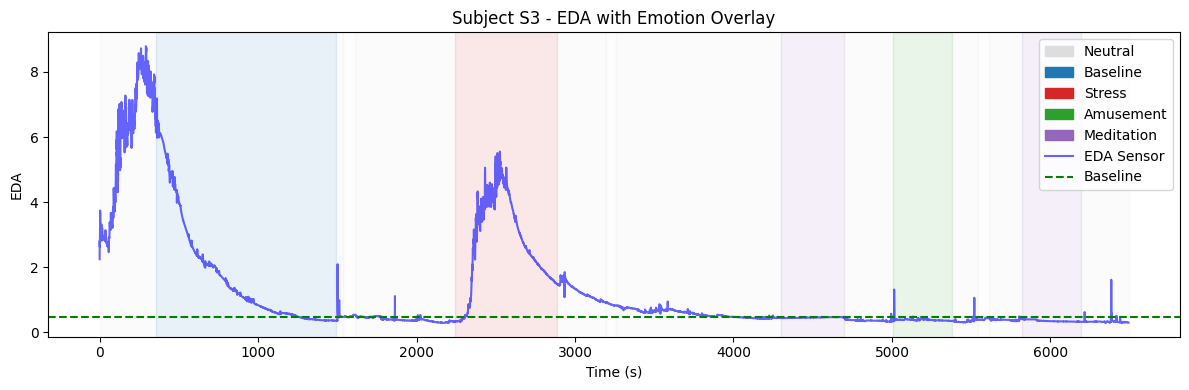

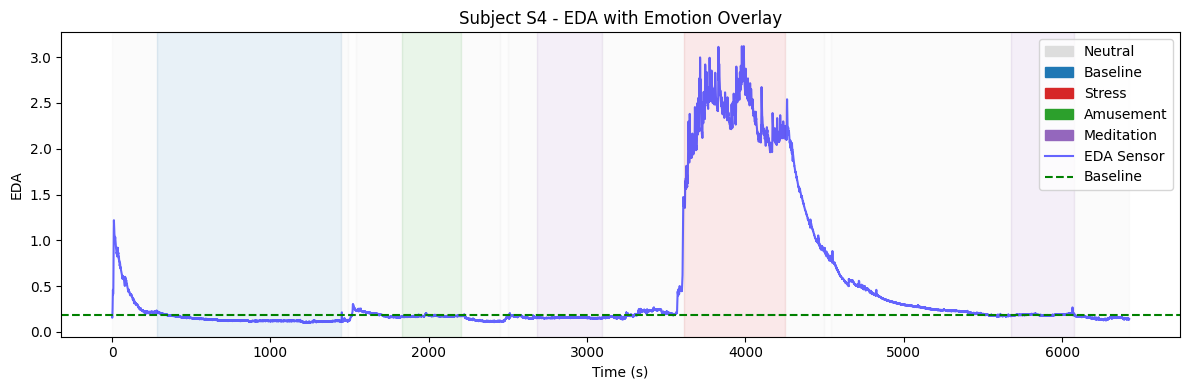

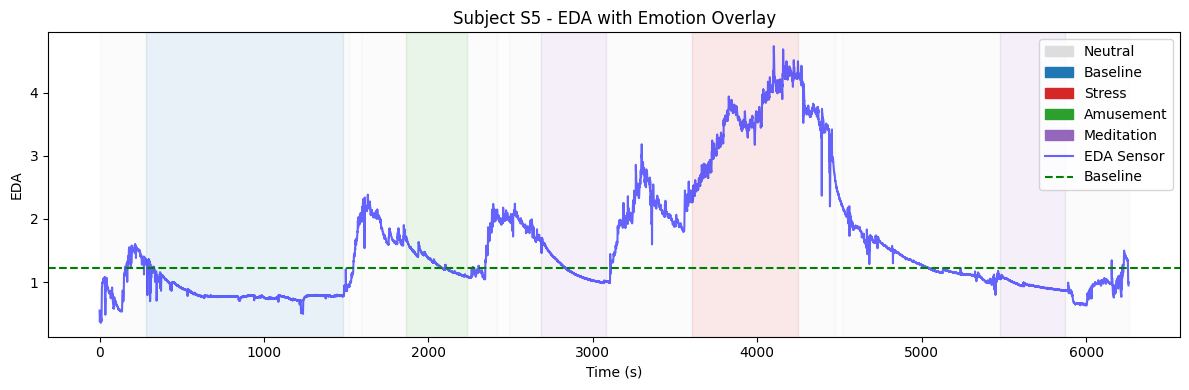

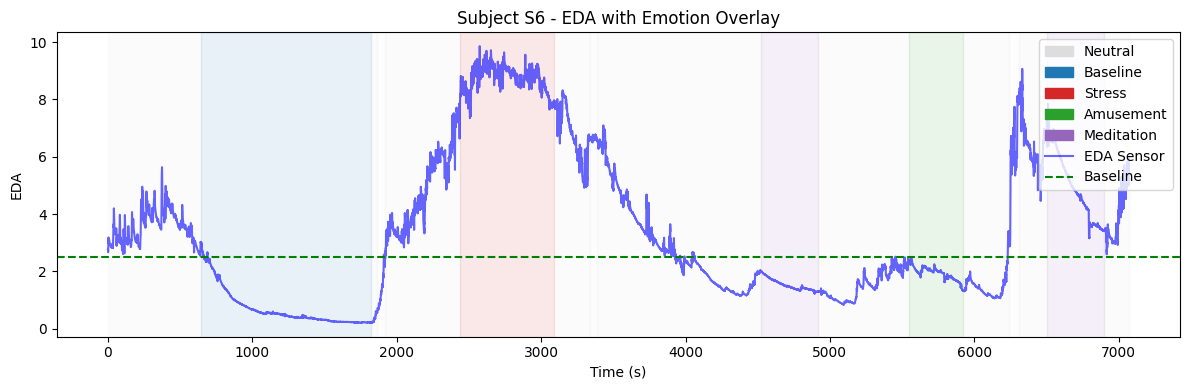

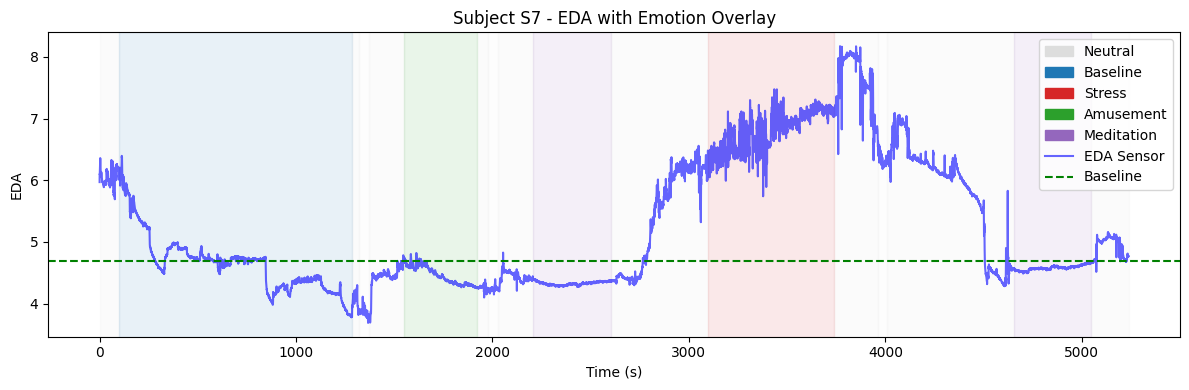

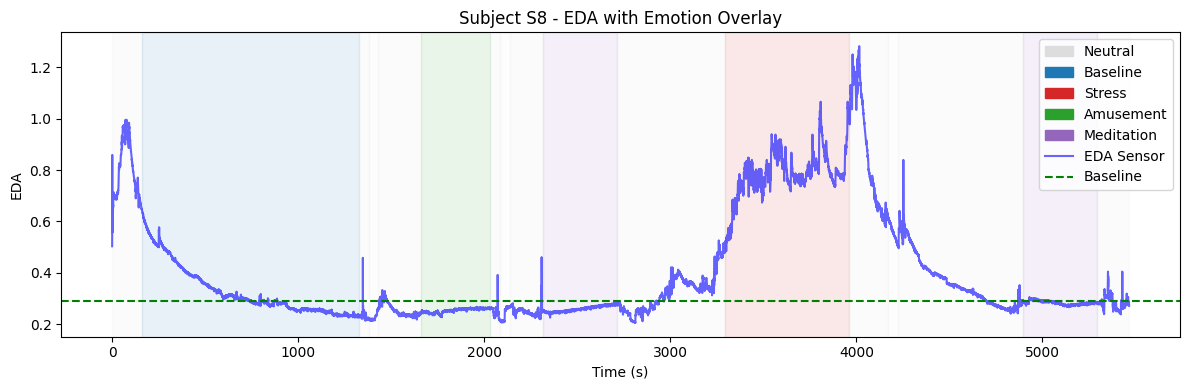

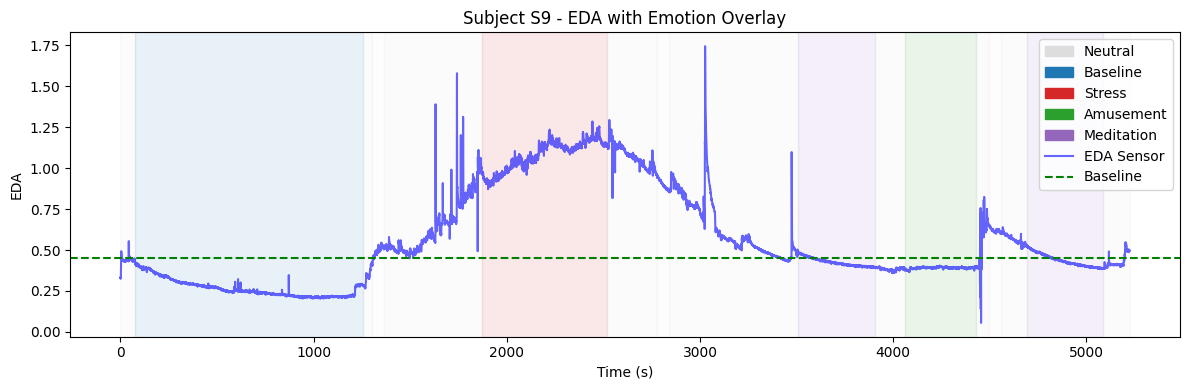

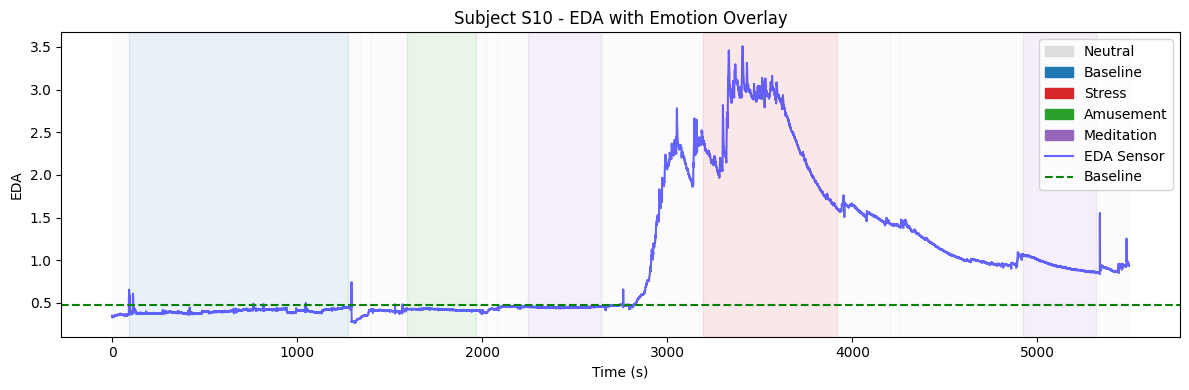

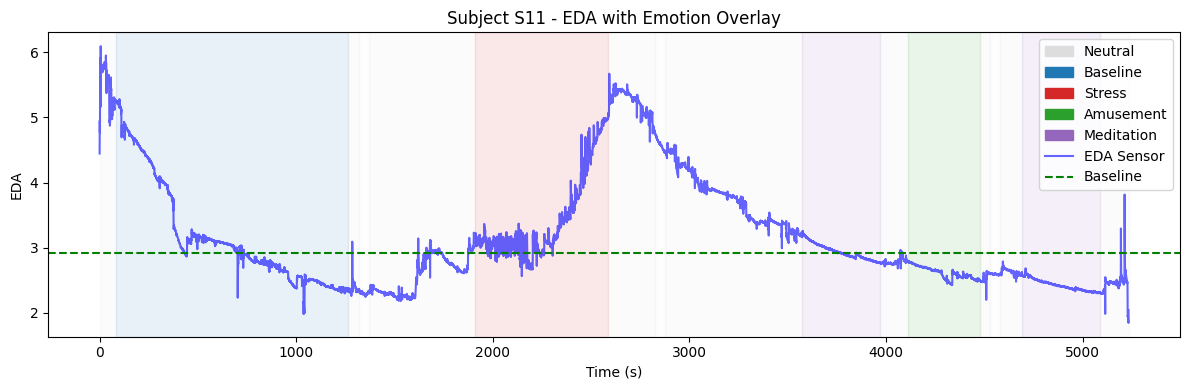

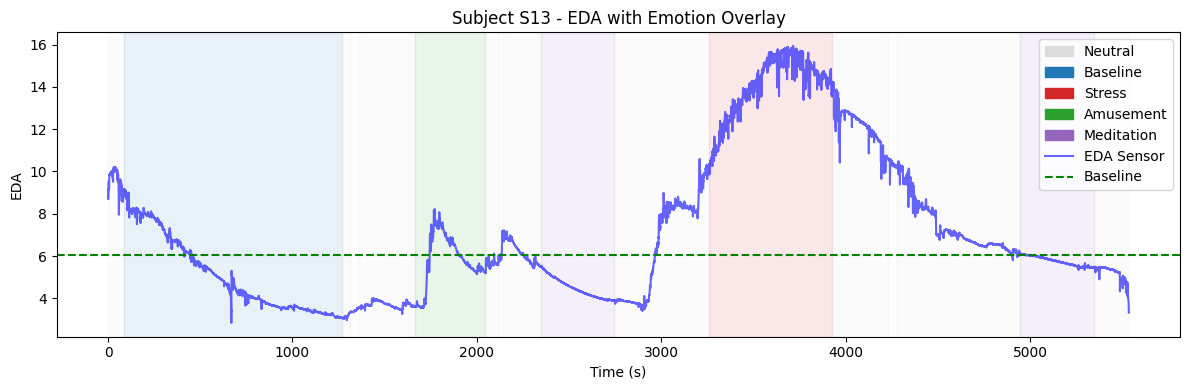

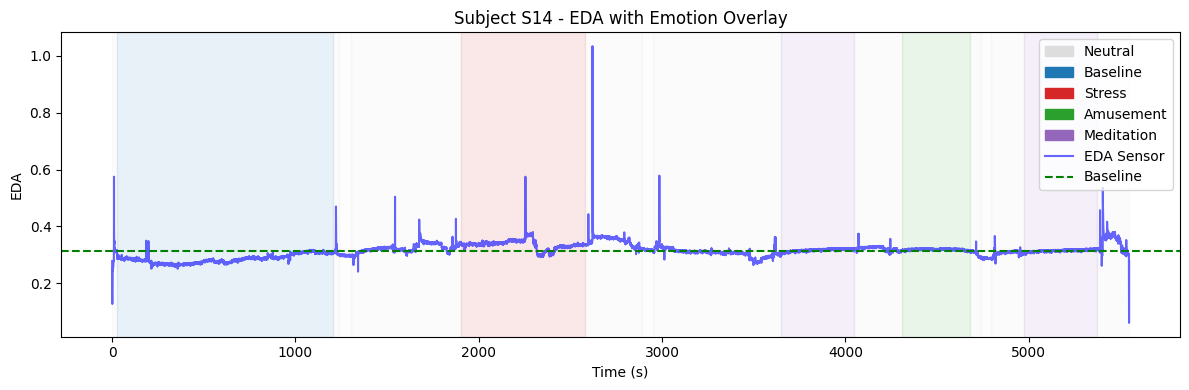

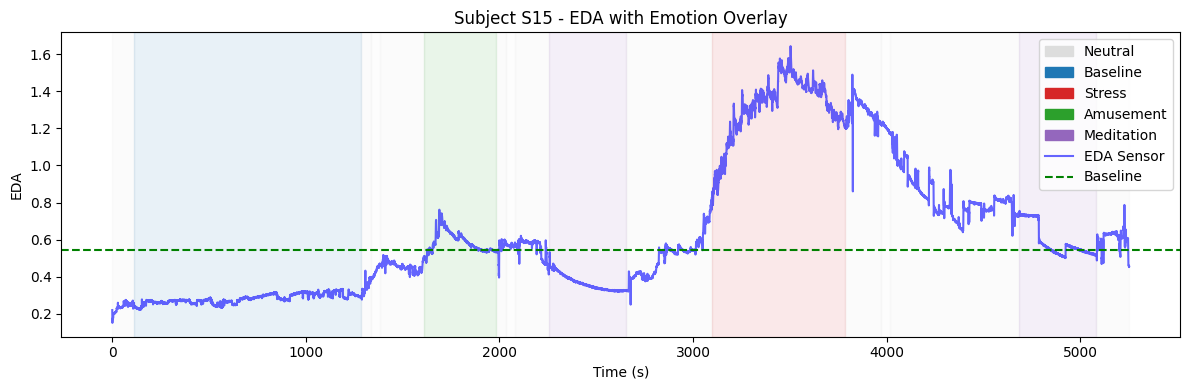

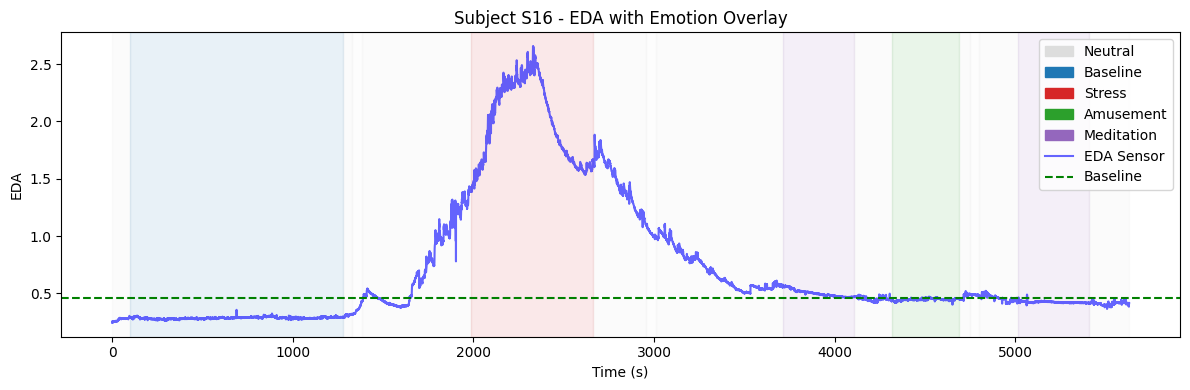

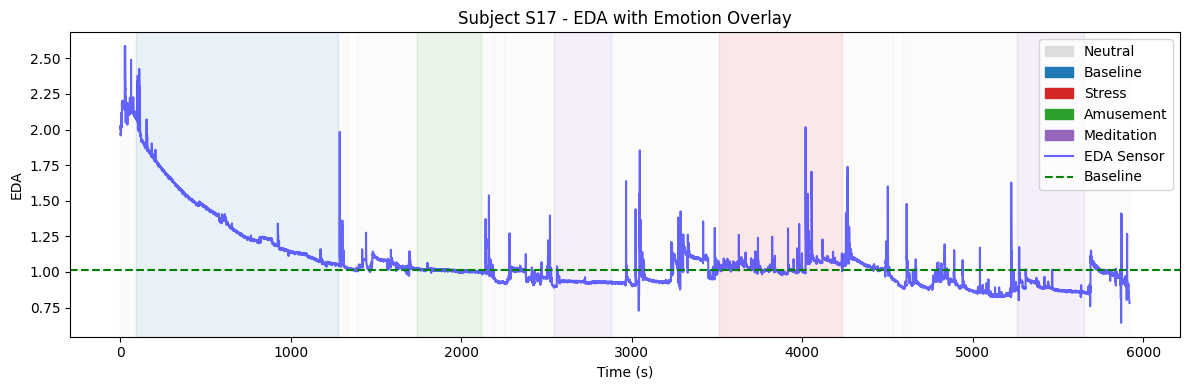

In [0]:
plot_sensor_graph(dataframe, ['EDA'])

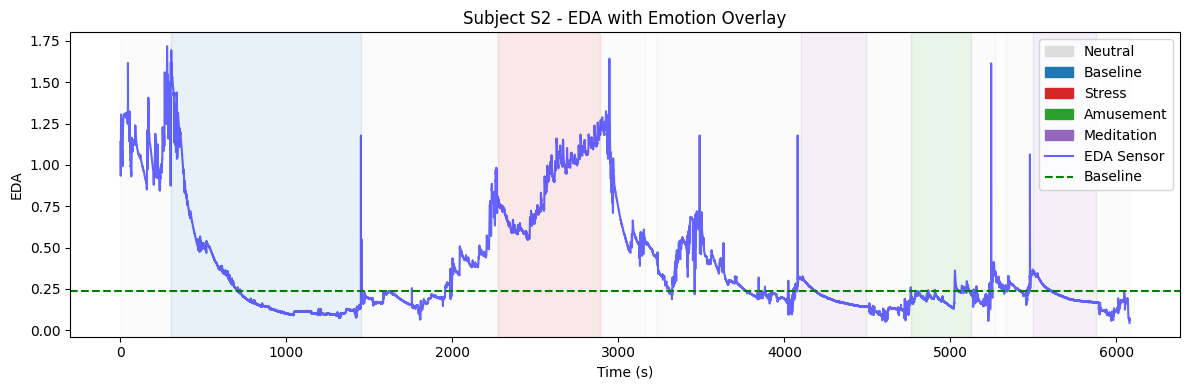

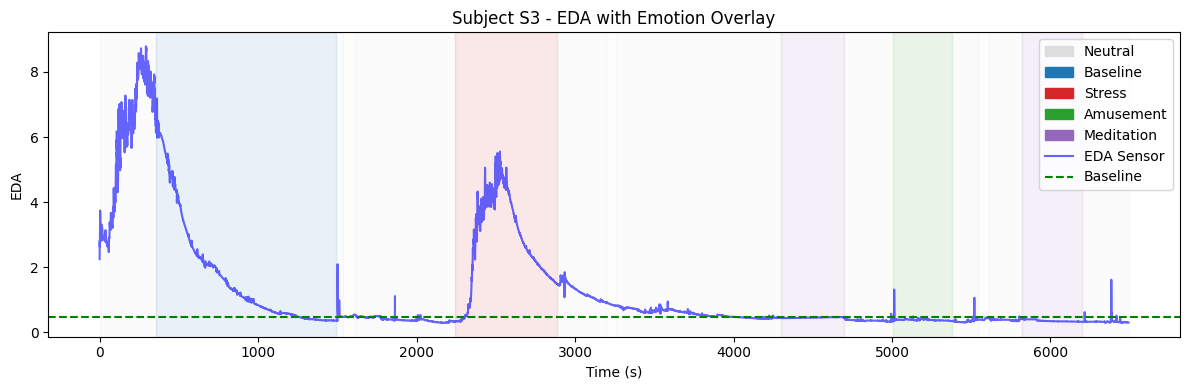

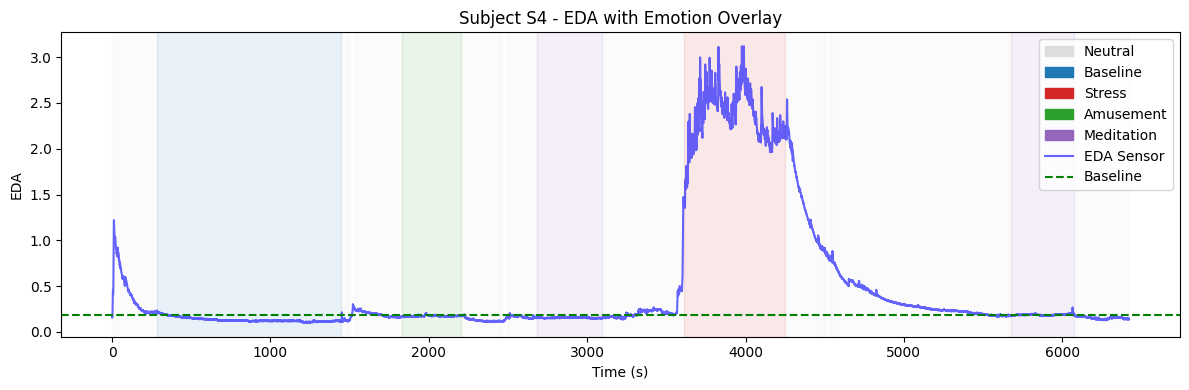

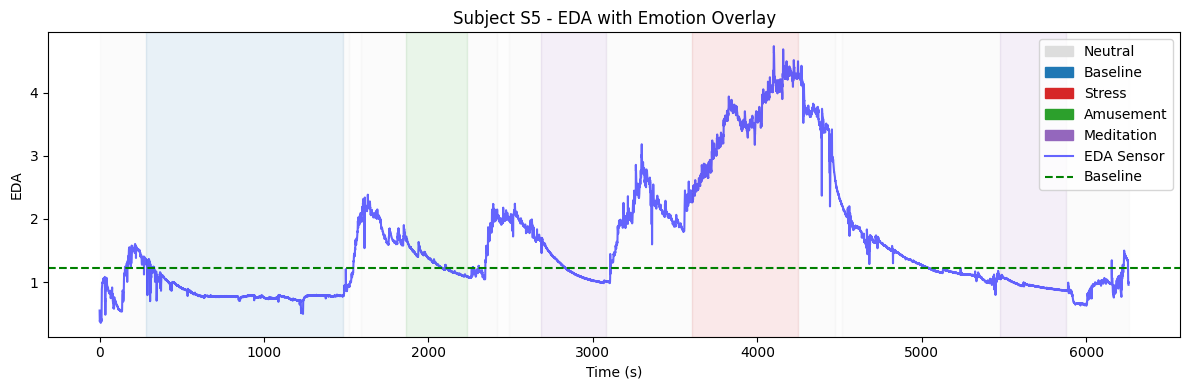

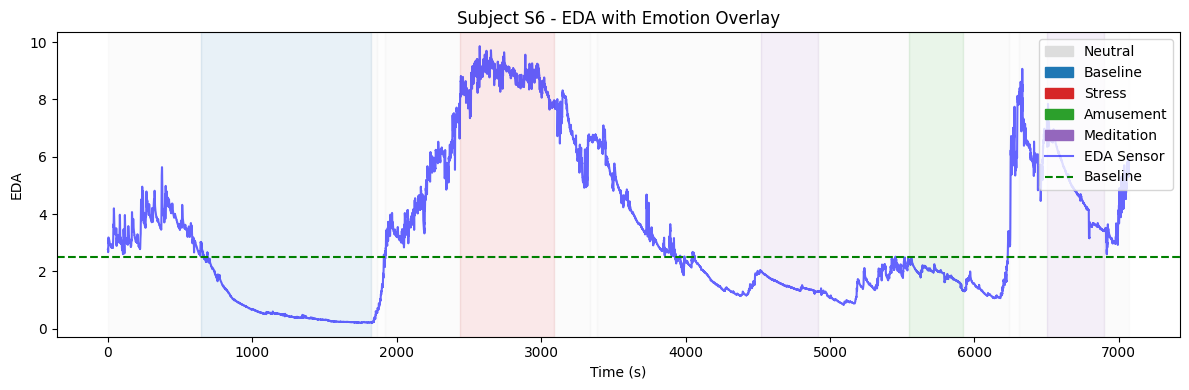

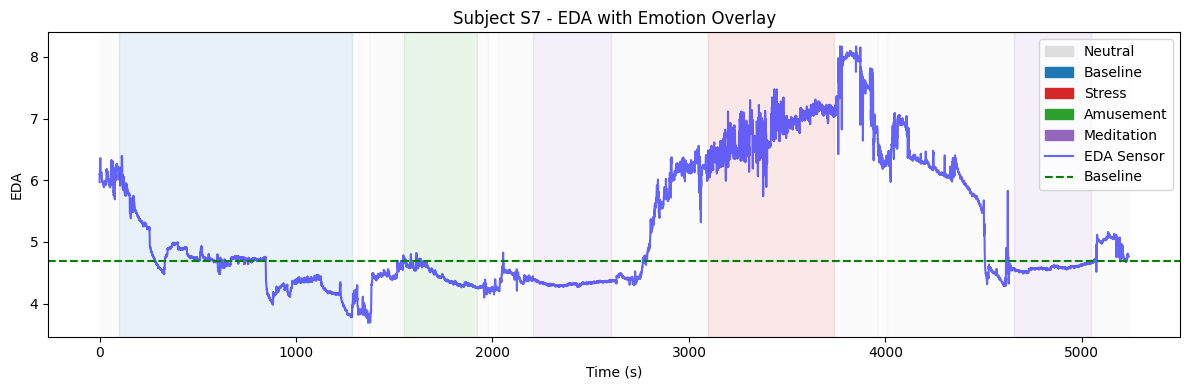

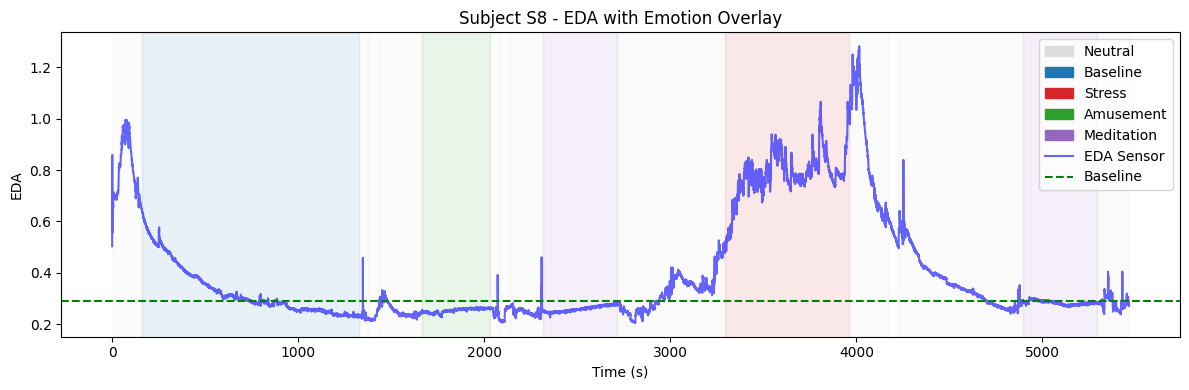

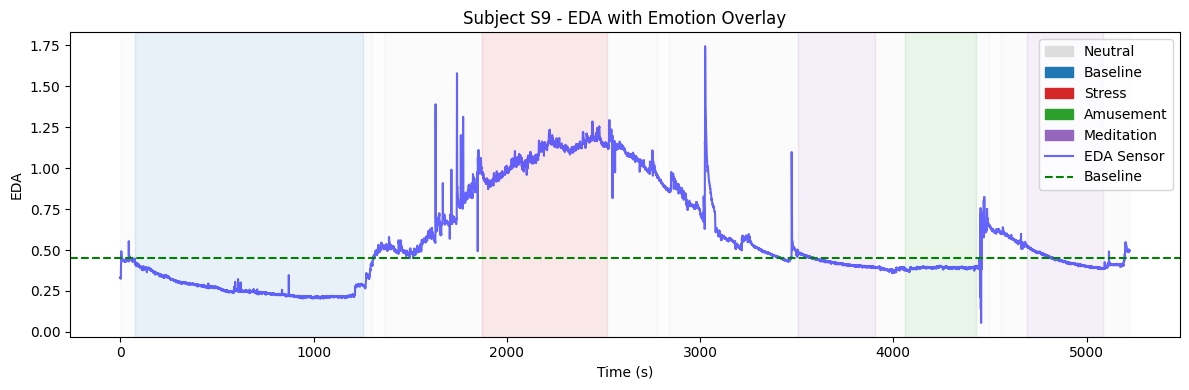

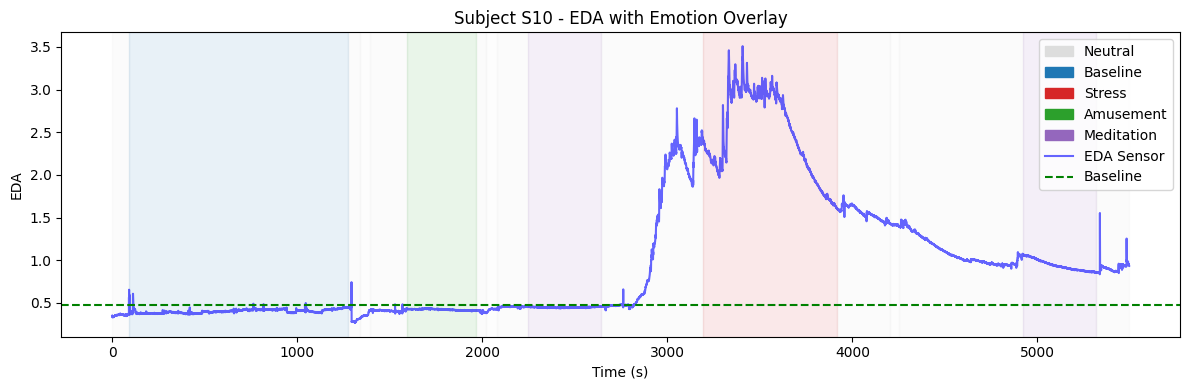

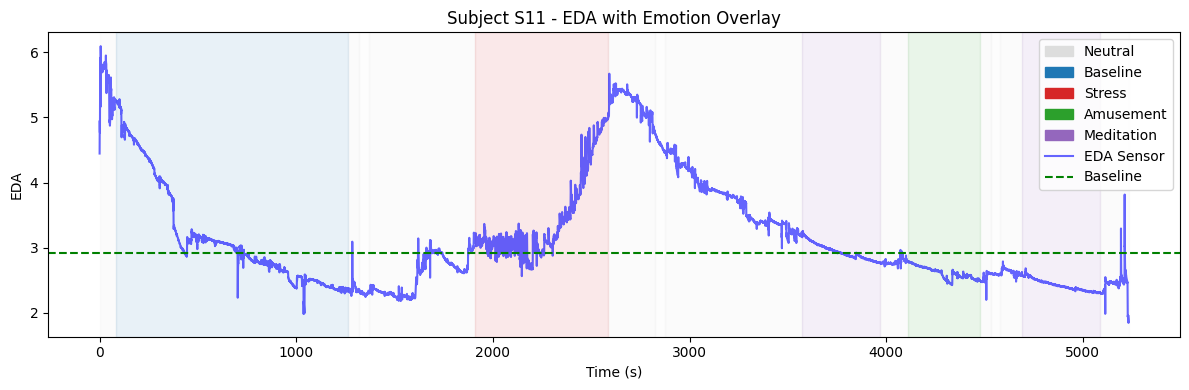

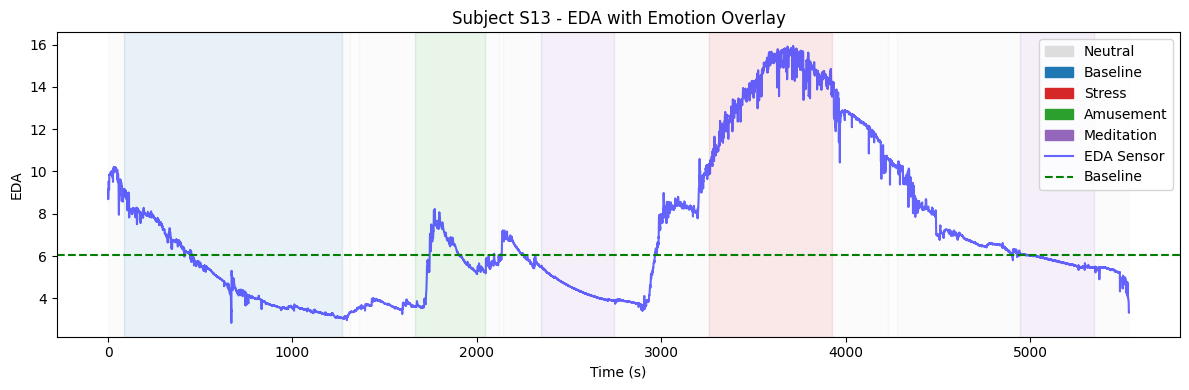

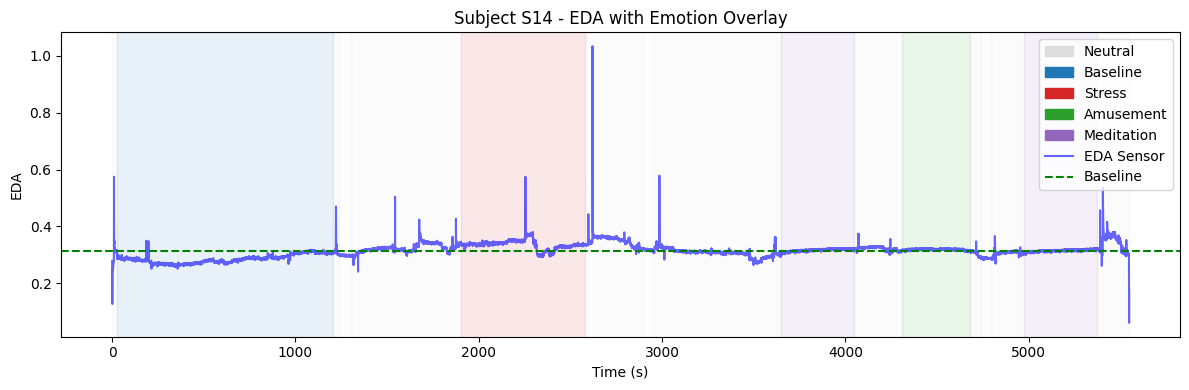

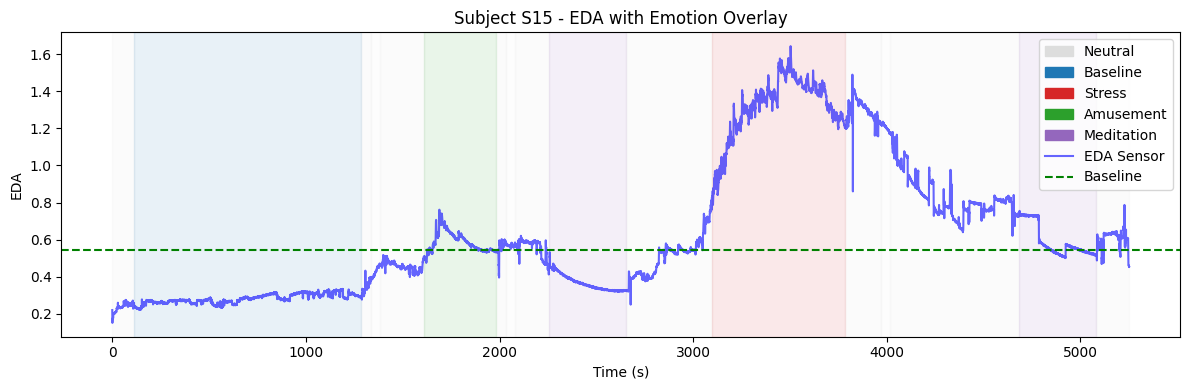

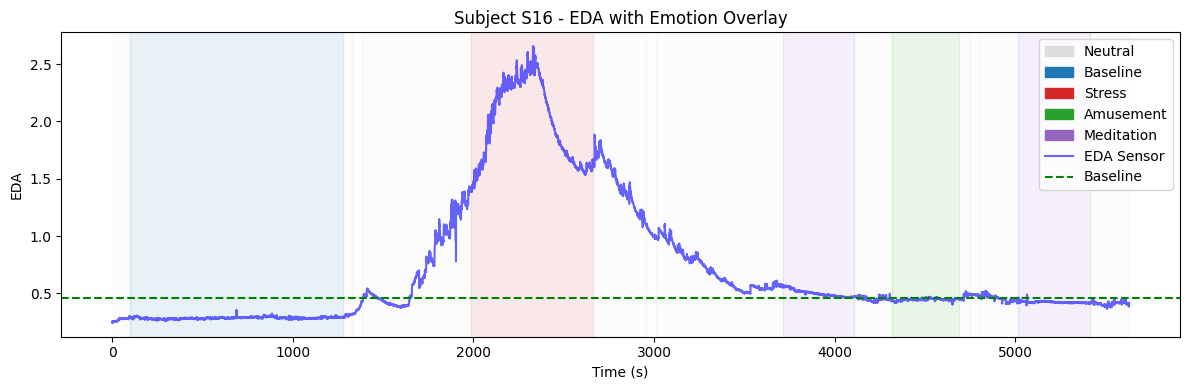

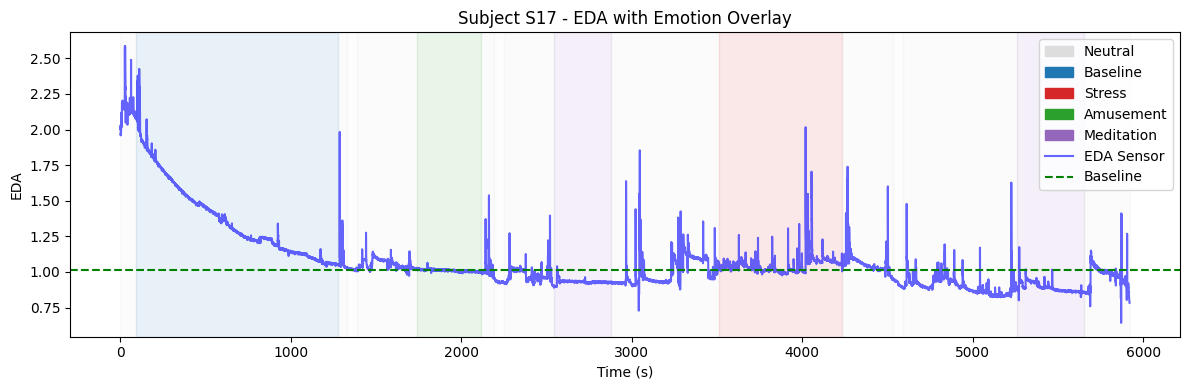

In [0]:
plot_sensor_graph(df, ['EDA'])

## Define Data short

In [0]:
data = dataframe[dataframe['labels']<=3]
data

,Unnamed: 0,Time (s),ACC_x,ACC_y,ACC_z,BVP,EDA,TEMP,labels,Age,Height,Weight,Gender,Dominant Hand,Drank Coffee Today,Drank Coffee Last Hour,Did Sports Today,Smoker,Smoked Last Hour,Feel Ill Today,Subject
0,0,0.000,62.0,-21.0,107.0,-59.370,1.138257,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
1,1,0.025,65.2,6.2,63.8,-48.008,1.136976,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
2,2,0.050,51.0,10.6,30.2,-30.694,1.135694,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
3,3,0.075,45.4,11.8,18.6,-10.822,1.134413,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
4,4,0.100,52.4,15.8,26.0,7.580,1.133132,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474715,3474715,5919.875,-43.0,-44.0,-54.0,0.950,0.782691,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
3474716,3474716,5919.900,-39.0,-43.2,-85.2,-0.576,0.782563,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
3474717,3474717,5919.925,-14.0,-48.4,-100.2,-2.328,0.782435,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
3474718,3474718,5919.950,-50.0,3.2,-12.2,-4.200,0.782307,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17


In [0]:
data_dos = df[df['labels']<=3]
data_dos

,Unnamed: 0,Time (s),ACC_x,ACC_y,ACC_z,BVP,EDA,TEMP,labels,Age,Height,Weight,Gender,Dominant Hand,Drank Coffee Today,Drank Coffee Last Hour,Did Sports Today,Smoker,Smoked Last Hour,Feel Ill Today,Subject
0,0,0.00,62,-21,107,-59.37,1.138257,35.41,0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
1,1,0.25,51,16,35,43.50,1.125444,35.41,0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
2,2,0.50,53,21,-6,53.56,1.011405,35.41,0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
3,3,0.75,55,17,34,54.64,1.033188,35.41,0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
4,4,1.00,48,24,15,-117.88,0.935807,35.41,0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347467,347467,5918.75,-52,-38,-5,3.52,0.792287,31.81,0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
347468,347468,5919.00,-53,-37,-4,7.15,0.787170,31.81,0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
347469,347469,5919.25,-52,-38,-4,-4.62,0.787170,31.81,0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
347470,347470,5919.50,-52,-38,-4,4.99,0.784611,31.81,0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17


## Model Building Pipeline Functions:
-- Preprocess_df : one-hot encoding and standard scaler

-- evaluate_model : Using Eval set to Evaluatethe classifier built

-- show_model_performance : Printer Function to display model performance on test and eval set

-- GetFeature_names : getting the features created post preprocessing

-- get_feature_importance : getting the top n features that impact the model

In [0]:
def preprocess_df(df, preprocessor=None, target_column='labels'):
    """
    One‐hot encode categorical cols and scale numeric cols.
    If `preprocessor` is None, fits on df and returns it.
    Otherwise uses provided preprocessor to transform df.

    Returns:
        processed_df: pd.DataFrame with encoded+scaled features + target column
        preprocessor: fitted ColumnTransformer
    """
    df = df.copy()
    # Drop Subject if present
    df.drop(columns=['Subject'], errors='ignore', inplace=True)

    # Separate out target
    y = df[target_column]
    X = df.drop(columns=[target_column])

    # Identify columns
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Build transformer if needed
    if preprocessor is None:
        preprocessor = ColumnTransformer(transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('num', StandardScaler(), num_cols)
        ])
        X_trans = preprocessor.fit_transform(X)
    else:
        X_trans = preprocessor.transform(X)

    # Build DataFrame of transformed features
    # get_feature_names_out requires scikit-learn ≥1.0
    onehot_cols = (
        preprocessor.named_transformers_['cat']
                    .get_feature_names_out(cat_cols)
        if cat_cols else []
    )
    all_cols = list(onehot_cols) + num_cols
    X_df = pd.DataFrame(X_trans, columns=all_cols, index=df.index)

    # attach target
    X_df[target_column] = y.values
    return X_df, preprocessor

def evaluate_model_on_df(model, df, target_column='labels'):
    """
    Evaluates `model` on a separate df and returns the same metrics dict.
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]


    # print(f"▶️ Evaluating Model on {df['Subject'].unique()}...")
    y_pred = model.predict(X)

    acc = accuracy_score(y, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y, y_pred, average='weighted', zero_division=0
    )
    per_cls = precision_recall_fscore_support(
        y, y_pred, average=None, zero_division=0, labels=np.unique(y)
    )

    metrics = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'per_class': per_cls
    }
    print(f"▶️Evaluation Metrics Fetched")

    return metrics, y, y_pred

def plot_confusion_matrix(y_true, y_pred, title):
    """Plot confusion matrix with annotations"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def print_results_table(results):
    """Display results in a formatted table"""
    display(HTML(
        pd.DataFrame(results)
        .style.set_properties(**{'text-align': 'center'})
        .set_table_styles([{
            'selector': 'th',
            'props': [('text-align', 'center')]
        }])
        .hide(axis='index')
        .to_html()
    ))

def _get_feature_names(preprocessor):
    """
    Recover the output feature names from a fitted ColumnTransformer
    that does OneHotEncoder + StandardScaler in two blocks.
    """
    # 1) categorical feature names
    cat_name, cat_trans, cat_cols = preprocessor.transformers_[0]
    if hasattr(cat_trans, 'get_feature_names_out'):
        cat_features = cat_trans.get_feature_names_out(cat_cols)
    else:
        # fallback
        cat_features = cat_trans.get_feature_names(cat_cols)

    # 2) numeric feature names
    _, num_trans, num_cols = preprocessor.transformers_[1]
    num_features = list(num_cols)

    return list(cat_features) + num_features

def get_feature_importance(model, preprocessor, top_n=None):
    """
    Returns a DataFrame of feature importances sorted descending.

    Parameters:
      - model: trained RandomForestClassifier (or any with .feature_importances_)
      - preprocessor: fitted ColumnTransformer used before model.fit()
      - top_n: if provided, only returns the top_n features

    Returns:
      DataFrame with columns ['feature', 'importance'], sorted descending.
    """
    feature_names = _get_feature_names(preprocessor)
    importances   = model.feature_importances_

    fi_df = (
        pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        .sort_values('Importance', ascending=False)
        .reset_index(drop=True)
    )

    if top_n:
        return fi_df.head(top_n)
    return fi_df

## Random Forest Baseline Model

In [0]:
#1. Random Forest Model Baseline Function
def train_random_forest_on_df(df, target_column='labels', test_size=0.2, random_state=42):
    """
    Splits df into 80/20, trains RandomForest, and returns:
      - model
      - train_metrics, test_metrics  (dicts with accuracy, precision, recall, f1, per_class)
    """
    # Split features/target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Train
    print('Building RF Classifier Model...')
    model = RandomForestClassifier(random_state=random_state)
    model.fit(X_train, y_train)

    def _metrics(y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted'
        )
        per_cls = precision_recall_fscore_support(
            y_true, y_pred, average=None, labels=np.unique(y_true)
        )
        return {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'per_class': per_cls
        }

    train_metrics = _metrics(y_train, model.predict(X_train))
    test_metrics  = _metrics(y_test,  model.predict(X_test))

    print("▶️ Training Complete")
    print("▶️ Testing Model...")
    print("Model, Training & Prediction metrics Fetched!")

    return model, train_metrics, test_metrics

In [0]:
# 2. Subset based on your function (assuming it filters by df['Subject'])
buildset = data_subsetting(data, build_subjects)
evalset = data_subsetting(data, eval_subjects)

# 3. Preprocess train, test, eval dfs using same pipeline.
df1_proc, preprocessor = preprocess_df(buildset)
df2_proc, _ = preprocess_df(evalset, preprocessor=preprocessor)

# 3. Train & test on df1_proc
model, train_m, test_m = train_random_forest_on_df(df1_proc)

# 4. Finally evaluate on df2_proc
eval_m, y_eval, y_pred = evaluate_model_on_df(model, df2_proc)

Building RF Classifier Model...


Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

▶️ Training Complete
▶️ Testing Model...
Model, Training & Prediction metrics Fetched!
▶️Evaluation Metrics Fetched


In [0]:
print_results_table(test_m)

accuracy,precision,recall,f1,per_class
0.999623,0.999623,0.999623,0.999623,[0.99959934 0.99975406 0.99941665 0.99974133]
0.999623,0.999623,0.999623,0.999623,[0.99970858 0.99959016 0.99956243 0.99922441]
0.999623,0.999623,0.999623,0.999623,[0.99965396 0.9996721 0.99948954 0.9994828 ]
0.999623,0.999623,0.999623,0.999623,[27452 12200 6856 3868]


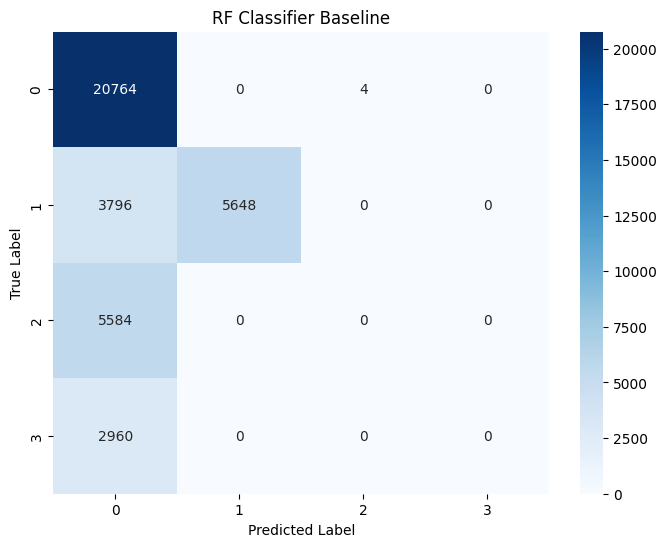

In [0]:
plot_confusion_matrix(y_eval, y_pred, 'RF Classifier Baseline')

In [0]:
# 2. Subset based on your function (assuming it filters by df['Subject'])
buildset = data_subsetting(data_dos, build_subjects)
evalset = data_subsetting(data_dos, eval_subjects)

# 3. Preprocess train, test, eval dfs using same pipeline.
df1_proc, preprocessor = preprocess_df(buildset)
df2_proc, _ = preprocess_df(evalset, preprocessor=preprocessor)

# 3. Train & test on df1_proc
model, train_m, test_m = train_random_forest_on_df(df1_proc)

# 4. Finally evaluate on df2_proc
eval_m, y_eval, y_pred = evaluate_model_on_df(model, df2_proc)

Building RF Classifier Model...


Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

▶️ Training Complete
▶️ Testing Model...
Model, Training & Prediction metrics Fetched!
▶️Evaluation Metrics Fetched


In [0]:
print_results_table(test_m)

accuracy,precision,recall,f1,per_class
0.999960,0.999960,0.999960,0.999960,[0.99996722 0.99995902 0.99994166 0.99994829]
0.999960,0.999960,0.999960,0.999960,[0.99995993 0.9999918 0.99991249 0.99994829]
0.999960,0.999960,0.999960,0.999960,[0.99996357 0.99997541 0.99992707 0.99994829]
0.999960,0.999960,0.999960,0.999960,[274520 122000 68560 38680]


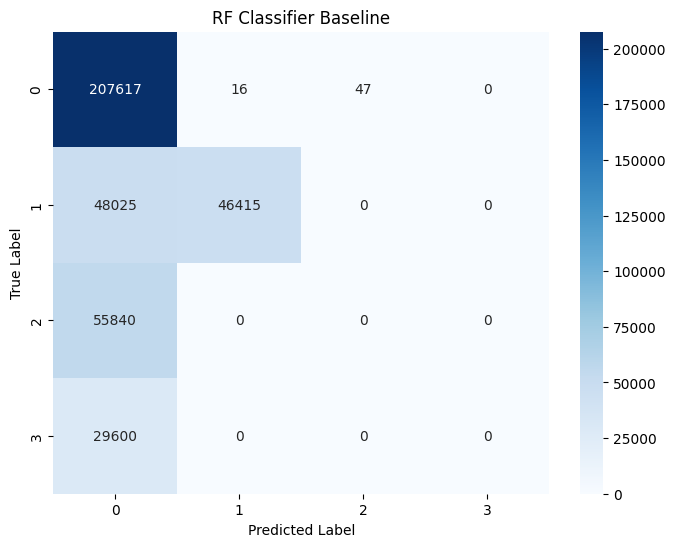

In [0]:
plot_confusion_matrix(y_eval, y_pred, 'RF Classifier Baseline')

In [0]:
# # Get all importances, sorted
# fi_top10 = get_feature_importance(model, preprocessor, top_n=10)
# fi_top10

## XG Boost Baseline

In [0]:
def train_xgboost_on_df(df, target_column='labels',
                        test_size=0.2, random_state=42):
    """
    Splits df into 80/20, trains XGBClassifier, and returns:
      - model
      - train_metrics, test_metrics  (dicts with accuracy, precision, recall, f1, per_class)
    """
    # 1️⃣ Split features/target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # 2️⃣ Train XGBoost
    model = XGBClassifier(
        random_state=random_state,
        use_label_encoder=False,    # suppress warning
        eval_metric='mlogloss'      # multiclass logloss
    )
    model.fit(X_train, y_train)

    # 3️⃣ Metrics helper
    def _metrics(y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted'
        )
        per_cls = precision_recall_fscore_support(
            y_true, y_pred, average=None, labels=np.unique(y_true)
        )
        return {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'per_class': per_cls
        }

    train_metrics = _metrics(y_train, model.predict(X_train))
    test_metrics  = _metrics(y_test,  model.predict(X_test))

    # print("▶️ XGB Training Metrics:", train_metrics)
    # print("▶️ XGB Testing Metrics: ", test_metrics)

    return model, train_metrics, test_metrics


In [0]:
# 1. Subset & preprocess exactly as before
buildset = data_subsetting(data, build_subjects)
evalset  = data_subsetting(data, eval_subjects)

df1_proc, preprocessor = preprocess_df(buildset)
df2_proc, _            = preprocess_df(evalset, preprocessor=preprocessor)

# 2. Train/test with XGBoost
xgb_model, xgb_train_m, xgb_test_m = train_xgboost_on_df(df1_proc)

# 3. Finally evaluate held-out subjects
xgb_eval_m, xg_y_eval, xg_y_pred = evaluate_model_on_df(xgb_model, df2_proc)

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

▶️Evaluation Metrics Fetched


In [0]:
print_results_table(xgb_test_m)

accuracy,precision,recall,f1,per_class
0.997082,0.997082,0.997082,0.997082,[0.99723204 0.99844237 0.99635409 0.99301242]
0.997082,0.997082,0.997082,0.997082,[0.99741367 0.99827869 0.99649942 0.99198552]
0.997082,0.997082,0.997082,0.997082,[0.99732284 0.99836052 0.99642675 0.99249871]
0.997082,0.997082,0.997082,0.997082,[27452 12200 6856 3868]


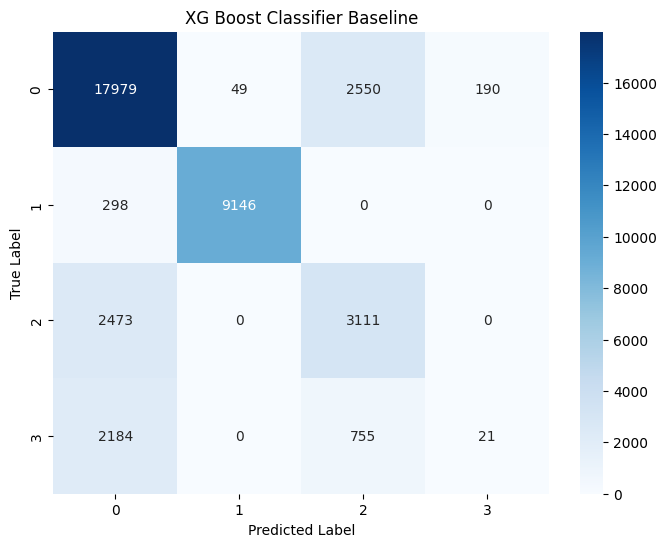

In [0]:
plot_confusion_matrix(xg_y_eval, xg_y_pred, 'XG Boost Classifier Baseline')

In [0]:
# 1. Subset & preprocess exactly as before
buildset = data_subsetting(data_dos, build_subjects)
evalset  = data_subsetting(data_dos, eval_subjects)

df1_proc, preprocessor = preprocess_df(buildset)
df2_proc, _            = preprocess_df(evalset, preprocessor=preprocessor)

# 2. Train/test with XGBoost
xgb_model, xgb_train_m, xgb_test_m = train_xgboost_on_df(df1_proc)

# 3. Finally evaluate held-out subjects
xgb_eval_m, xg_y_eval, xg_y_pred = evaluate_model_on_df(xgb_model, df2_proc)

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

▶️Evaluation Metrics Fetched


In [0]:
print_results_table(xgb_test_m)

accuracy,precision,recall,f1,per_class
0.998273,0.998274,0.998273,0.998273,[0.99869154 0.99908218 0.99728887 0.99450436]
0.998273,0.998274,0.998273,0.998273,[0.99813857 0.99931148 0.99795799 0.99650982]
0.998273,0.998274,0.998273,0.998273,[0.99841498 0.99919681 0.99762332 0.99550608]
0.998273,0.998274,0.998273,0.998273,[274520 122000 68560 38680]


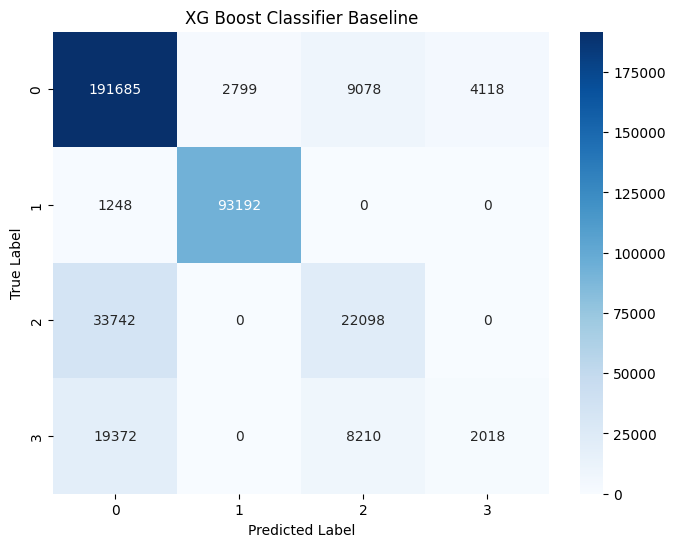

In [0]:
plot_confusion_matrix(xg_y_eval, xg_y_pred, 'XG Boost Classifier Baseline')

In [0]:
# Ensure we only keep classes 0,1,2
data = data[data['labels'].isin([0, 1, 2])].copy()
print("Label distribution after filtering:")
print(data['labels'].value_counts())

Label distribution after filtering:
0.0    1580280
1.0     704440
2.0     398640
Name: labels, dtype: int64


In [0]:
data_dos = data_dos[data_dos['labels'].isin([0, 1, 2])].copy()
print("Label distribution after filtering:")
print(data_dos['labels'].value_counts())

Label distribution after filtering:
0    158028
1     70444
2     39864
Name: labels, dtype: int64


## Models

In [0]:
# 1. Advanced Feature Engineering
def create_time_features(df, window_size=5):
    """Create rolling window features for physiological signals"""
    features = ['EDA', 'TEMP', 'BVP', 'ACC_x', 'ACC_y', 'ACC_z']
    new_features = []

    for feature in features:
        # Rolling statistics
        df[f'{feature}_mean'] = df[feature].rolling(window=window_size).mean()
        df[f'{feature}_std'] = df[feature].rolling(window=window_size).std()
        df[f'{feature}_max'] = df[feature].rolling(window=window_size).max()
        df[f'{feature}_min'] = df[feature].rolling(window=window_size).min()

        # Difference features
        df[f'{feature}_diff'] = df[feature].diff()

        new_features.extend([
            f'{feature}_mean', f'{feature}_std',
            f'{feature}_max', f'{feature}_min',
            f'{feature}_diff'
        ])

    return df, features + new_features

def subject_wise_split(data, test_subjects=['S16', 'S17']):
    """Ensure completely unseen subjects in test set"""
    train_data = data[~data['Subject'].isin(test_subjects)]
    test_data = data[data['Subject'].isin(test_subjects)]

    X_train = train_data[all_features]
    y_train = train_data['labels']
    X_test = test_data[all_features]
    y_test = test_data['labels']

    return X_train, X_test, y_train, y_test

def build_attention_model(input_shape, num_classes=3):
    """LSTM with attention mechanism"""
    inputs = tf.keras.Input(shape=input_shape)

    # Bi-directional LSTM
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = Dropout(0.3)(x)

    # Attention mechanism
    attention = Dense(1, activation='tanh')(x)
    attention = tf.keras.layers.Flatten()(attention)
    attention = tf.keras.layers.Activation('softmax')(attention)
    attention = tf.keras.layers.RepeatVector(64*2)(attention)  # 64*2 for bidirectional
    attention = tf.keras.layers.Permute([2, 1])(attention)

    # Apply attention
    x = tf.keras.layers.Multiply()([x, attention])
    x = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(x)

    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Train and evaluate model with comprehensive metrics"""
    # Train model
    history = model.fit(
    X_train_seq,
    y_train_cat,
    epochs=50,  # Increased from 20
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,  # Added
    verbose=1)

    # Evaluate
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Metrics
    acc = accuracy_score(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes)
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(report)

    return history

def cross_validate_loso(X, y, groups, model_builder):
    """Leave-One-Subject-Out cross validation for LSTM models"""
    logo = LeaveOneGroupOut()
    accuracies = []

    # Ensure input is 3D [samples, timesteps, features]
    if len(X.shape) == 2:
        X = X.reshape((X.shape[0], 1, X.shape[1]))

    for train_idx, test_idx in logo.split(X, y, groups=groups):
        subject = np.unique(groups[test_idx])[0]
        print(f"\nEvaluating on subject {subject}")

        # Get 3D sequences
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Verify shapes
        print(f"X_train shape: {X_train.shape}")
        print(f"X_test shape: {X_test.shape}")

        # Build model with correct input shape
        model = model_builder(X_train.shape[1:], y_train.shape[1])

        # Train
        model.fit(X_train, y_train,
                epochs=15,
                batch_size=64,
                verbose=0)

        # Evaluate
        y_pred = np.argmax(model.predict(X_test), axis=1)
        y_true = np.argmax(y_test, axis=1)
        acc = accuracy_score(y_true, y_pred)
        accuracies.append(acc)
        print(f"Subject {subject} accuracy: {acc:.4f}")

    print("\nCross-validation results:")
    print(f"Mean accuracy: {np.mean(accuracies):.4f}")
    print(f"Std deviation: {np.std(accuracies):.4f}")
    return accuracies


Categorical features: []
Numerical features: ['EDA', 'TEMP', 'BVP', 'ACC_x', 'ACC_y'] ...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

2025-05-07 18:49:37.683402: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


Random Forest Results:
              precision    recall  f1-score   support

         0.0       0.68      0.72      0.70    207680
         1.0       0.64      0.38      0.48     94440
         2.0       0.10      0.15      0.12     55840

    accuracy                           0.54    357960
   macro avg       0.47      0.42      0.43    357960
weighted avg       0.58      0.54      0.55    357960

Accuracy: 0.5430


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


XGBoost Results:
              precision    recall  f1-score   support

         0.0       0.68      0.85      0.75    207680
         1.0       0.74      0.44      0.55     94440
         2.0       0.05      0.04      0.05     55840

    accuracy                           0.61    357960
   macro avg       0.49      0.44      0.45    357960
weighted avg       0.60      0.61      0.59    357960

Accuracy: 0.6142
Epoch 1/50


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1956/29068 ━━━━━━━━━━━━━━━━━━━━ 1:34 3ms/step - accuracy: 0.7645 - loss: 0.5269

*** WARNING: max output size exceeded, skipping output. ***

29068/29068 ━━━━━━━━━━━━━━━━━━━━ 116s 4ms/step - accuracy: 0.9703 - loss: 0.0779 - val_accuracy: 0.4543 - val_loss: 17.6041 - learning_rate: 5.0000e-04
    1/11187 ━━━━━━━━━━━━━━━━━━━━ 1:16:55 413ms/step

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


11187/11187 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step


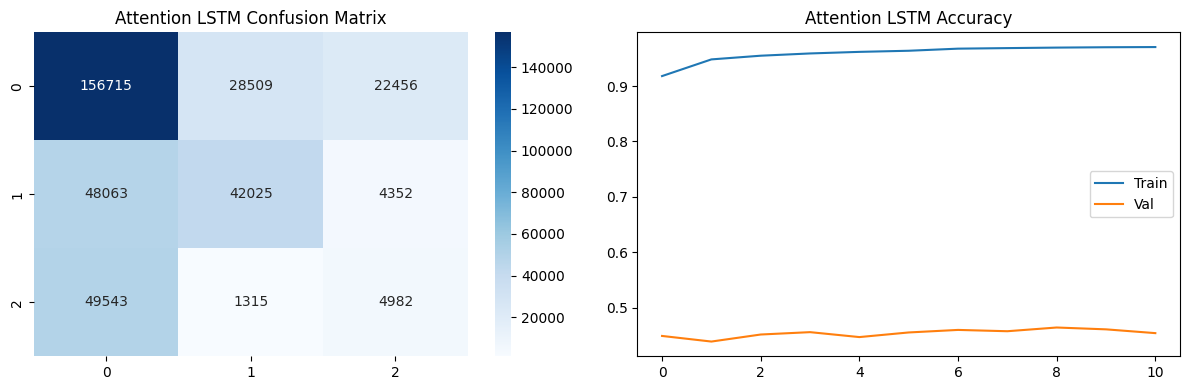


Attention LSTM Results:
Accuracy: 0.5691

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68    207680
           1       0.58      0.44      0.51     94440
           2       0.16      0.09      0.11     55840

    accuracy                           0.57    357960
   macro avg       0.45      0.43      0.43    357960
weighted avg       0.54      0.57      0.54    357960



/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

No categorical features were processed - proceeding with numerical features only


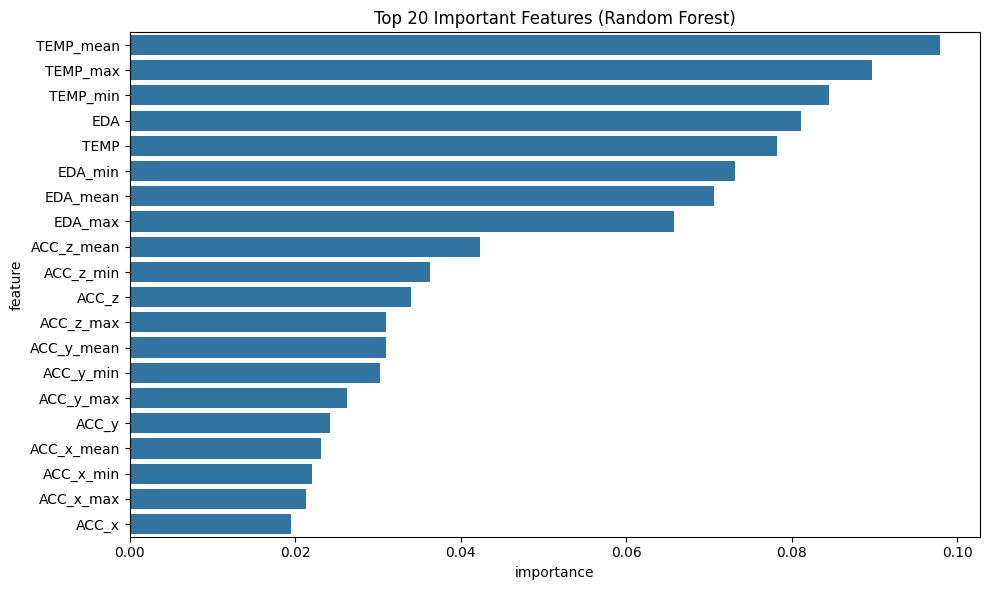


=== LOSO Cross-Validation ===

Evaluating on subject S10
X_train shape: (2158400, 1, 36)
X_test shape: (167000, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


   1/5219 ━━━━━━━━━━━━━━━━━━━━ 37:52 435ms/step

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5219/5219 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Subject S10 accuracy: 0.6694

Evaluating on subject S11
X_train shape: (2168520, 1, 36)
X_test shape: (156880, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


   1/4903 ━━━━━━━━━━━━━━━━━━━━ 30:38 375ms/step

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4903/4903 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Subject S11 accuracy: 0.7339

Evaluating on subject S13
X_train shape: (2155680, 1, 36)
X_test shape: (169720, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


  41/5304 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step     

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5304/5304 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Subject S13 accuracy: 0.6007

Evaluating on subject S14
X_train shape: (2157000, 1, 36)
X_test shape: (168400, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


  41/5263 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step     

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5263/5263 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Subject S14 accuracy: 0.4236

Evaluating on subject S15
X_train shape: (2167680, 1, 36)
X_test shape: (157720, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


  29/4929 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step     

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4929/4929 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Subject S15 accuracy: 0.5280

Evaluating on subject S2
X_train shape: (2132600, 1, 36)
X_test shape: (192800, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


  38/6025 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step     

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


6025/6025 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Subject S2 accuracy: 0.6006

Evaluating on subject S3
X_train shape: (2120160, 1, 36)
X_test shape: (205240, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


  34/6414 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step     

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


6414/6414 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Subject S3 accuracy: 0.6603

Evaluating on subject S4
X_train shape: (2121440, 1, 36)
X_test shape: (203960, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


  40/6374 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step     

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


6374/6374 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Subject S4 accuracy: 0.6596

Evaluating on subject S5
X_train shape: (2129240, 1, 36)
X_test shape: (196160, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


   1/6130 ━━━━━━━━━━━━━━━━━━━━ 44:59 440ms/step

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


6130/6130 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Subject S5 accuracy: 0.6424

Evaluating on subject S6
X_train shape: (2096000, 1, 36)
X_test shape: (229400, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


  38/7169 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step     

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7169/7169 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Subject S6 accuracy: 0.6548

Evaluating on subject S7
X_train shape: (2168240, 1, 36)
X_test shape: (157160, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


  39/4912 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step     

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4912/4912 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Subject S7 accuracy: 0.6302

Evaluating on subject S8
X_train shape: (2159480, 1, 36)
X_test shape: (165920, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


  38/5185 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step     

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5185/5185 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Subject S8 accuracy: 0.4929

Evaluating on subject S9
X_train shape: (2170360, 1, 36)
X_test shape: (155040, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


   1/4845 ━━━━━━━━━━━━━━━━━━━━ 35:23 438ms/step

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4845/4845 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Subject S9 accuracy: 0.4735

Cross-validation results:
Mean accuracy: 0.5977
Std deviation: 0.0874

LOSO Results:
Mean Accuracy: 0.60%
Std Deviation: 0.09
Per-subject accuracies: [0.6694491017964072, 0.7338666496685364, 0.6007247230732972, 0.42364014251781473, 0.5280243469439513, 0.6006068464730291, 0.6603342428376535, 0.6596195332418121, 0.6424092577487766, 0.6547907585004359, 0.630173072028506, 0.49293032786885244, 0.4734971620227038]


In [0]:
# Apply feature engineering
data, all_features = create_time_features(data.copy())
X_train, X_test, y_train, y_test = subject_wise_split(data)

# Separate numerical and categorical features
cat_features = [col for col in ['Gender', 'Dominant Hand'] if col in X_train.columns]
num_features = [col for col in all_features if col not in cat_features]
print("Categorical features:", cat_features)
print("Numerical features:", num_features[:5], "...")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features) if cat_features else ('passthrough', 'passthrough', [])
    ])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)]

if __name__ == "__main__":
    # Preprocess data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Convert to sequences for LSTM models
    X_train_seq = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], 1, X_train_preprocessed.shape[1]))
    X_test_seq = X_test_preprocessed.reshape((X_test_preprocessed.shape[0], 1, X_test_preprocessed.shape[1]))

    # Convert labels to categorical
    y_train_cat = to_categorical(y_train, num_classes=3)
    y_test_cat = to_categorical(y_test, num_classes=3)

    # Train and evaluate models
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=10, min_samples_leaf=5),
        "XGBoost": xgb.XGBClassifier(objective='multi:softmax', num_class=3, max_depth=6, learning_rate=0.1),
        "Attention LSTM": build_attention_model((1, X_train_preprocessed.shape[1]), 3)
    }

    for name, model in models.items():
        if name in ["Random Forest", "XGBoost"]:
            # Traditional ML models
            model.fit(X_train_preprocessed, y_train)
            y_pred = model.predict(X_test_preprocessed)

            print(f"\n{name} Results:")
            print(classification_report(y_test, y_pred))
            print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        else:
            # Deep learning models
            _ = evaluate_model(model, X_train_seq, y_train_cat, X_test_seq, y_test_cat, name)

    # Feature importance analysis
    rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=10, min_samples_leaf=5)
    rf.fit(X_train_preprocessed, y_train)

    # Get feature names after preprocessing
    num_feature_names = num_features

    # Handle categorical features if they exist
    if 'cat' in preprocessor.named_transformers_:
        cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_features)
    else:
        cat_feature_names = np.array([])
        print("No categorical features were processed - proceeding with numerical features only")

    all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

    # Plot feature importance
    importances = pd.DataFrame({
        'feature': all_feature_names,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importances.head(20))
    plt.title('Top 20 Important Features (Random Forest)')
    plt.tight_layout()
    plt.show()

    print("\n=== LOSO Cross-Validation ===")
    # Get subject IDs corresponding to X_train_preprocessed
    train_mask = ~data['Subject'].isin(['S16', 'S17'])
    train_subjects = data.loc[train_mask, 'Subject'].values

    # Use the SEQUENTIAL data (X_train_seq) not the preprocessed 2D data
    loso_accuracies = cross_validate_loso(X_train_seq, y_train_cat, groups=train_subjects, model_builder=lambda i,s: build_attention_model(i, 3))

    print("\nLOSO Results:")
    print(f"Mean Accuracy: {np .mean(loso_accuracies):.2f}%")
    print(f"Std Deviation: {np.std(loso_accuracies):.2f}")
    print(f"Per-subject accuracies: {loso_accuracies}")

Categorical features: []
Numerical features: ['EDA', 'TEMP', 'BVP', 'ACC_x', 'ACC_y'] ...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


Random Forest Results:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72     20768
           1       0.65      0.37      0.47      9444
           2       0.09      0.11      0.10      5584

    accuracy                           0.56     35796
   macro avg       0.47      0.42      0.43     35796
weighted avg       0.58      0.56      0.56     35796

Accuracy: 0.5590


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


XGBoost Results:
              precision    recall  f1-score   support

           0       0.69      0.85      0.76     20768
           1       0.83      0.57      0.68      9444
           2       0.10      0.06      0.08      5584

    accuracy                           0.66     35796
   macro avg       0.54      0.50      0.51     35796
weighted avg       0.63      0.66      0.63     35796

Accuracy: 0.6557
Epoch 1/50


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2147/2

*** WARNING: max output size exceeded, skipping output. ***

2907/2907 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9472 - loss: 0.1332 - val_accuracy: 0.4841 - val_loss: 10.2266 - learning_rate: 5.0000e-04
  40/1119 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step    

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1119/1119 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


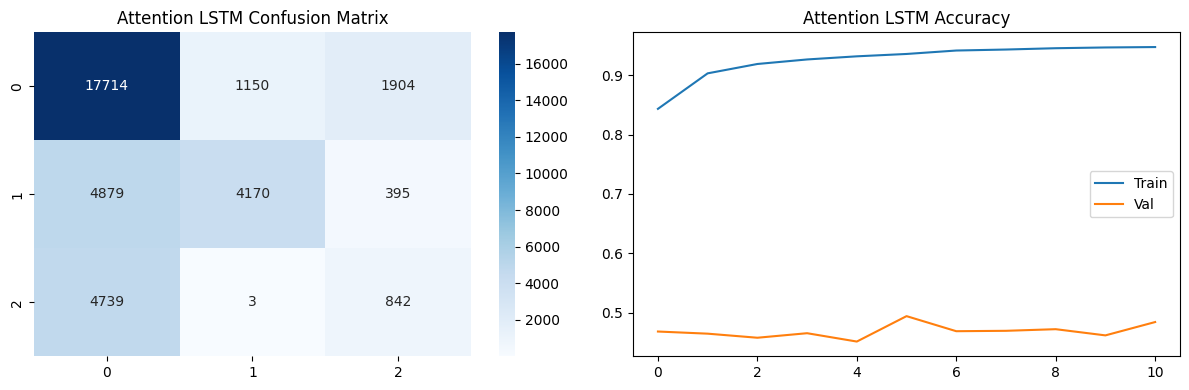


Attention LSTM Results:
Accuracy: 0.6349

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.85      0.74     20768
           1       0.78      0.44      0.56      9444
           2       0.27      0.15      0.19      5584

    accuracy                           0.63     35796
   macro avg       0.57      0.48      0.50     35796
weighted avg       0.62      0.63      0.61     35796



/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Uploading artifacts:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

No categorical features were processed - proceeding with numerical features only


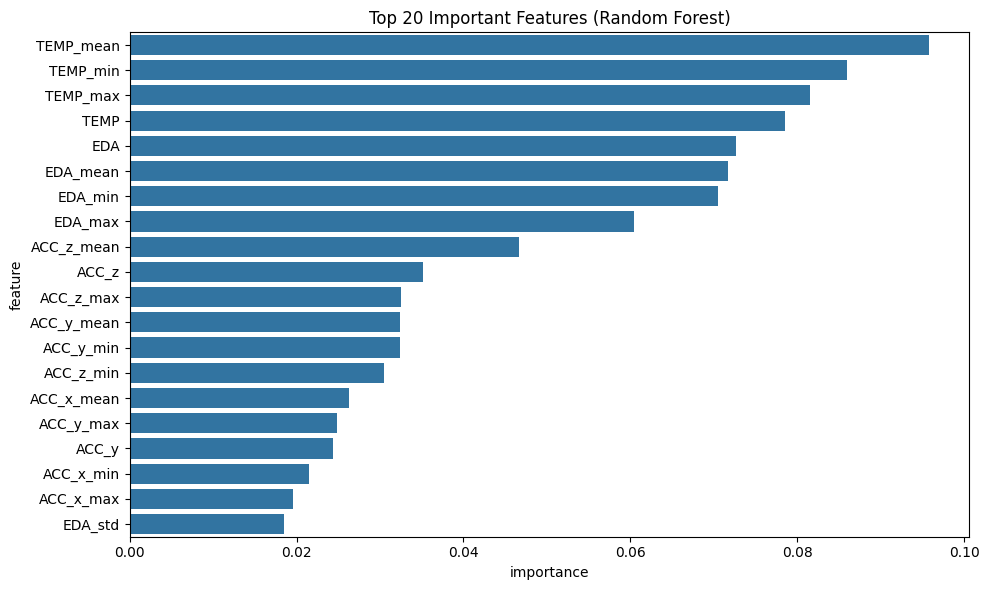


=== LOSO Cross-Validation ===

Evaluating on subject S10
X_train shape: (215840, 1, 36)
X_test shape: (16700, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 38/522 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step    

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Subject S10 accuracy: 0.6805

Evaluating on subject S11
X_train shape: (216852, 1, 36)
X_test shape: (15688, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 38/491 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step    

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


491/491 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Subject S11 accuracy: 0.7063

Evaluating on subject S13
X_train shape: (215568, 1, 36)
X_test shape: (16972, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 38/531 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step    

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Subject S13 accuracy: 0.6031

Evaluating on subject S14
X_train shape: (215700, 1, 36)
X_test shape: (16840, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 40/527 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step    

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


527/527 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Subject S14 accuracy: 0.4153

Evaluating on subject S15
X_train shape: (216768, 1, 36)
X_test shape: (15772, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 37/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step    

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Subject S15 accuracy: 0.5280

Evaluating on subject S2
X_train shape: (213260, 1, 36)
X_test shape: (19280, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 41/603 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step    

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


603/603 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Subject S2 accuracy: 0.6330

Evaluating on subject S3
X_train shape: (212016, 1, 36)
X_test shape: (20524, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


  1/642 ━━━━━━━━━━━━━━━━━━━━ 3:22 316ms/step

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


642/642 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Subject S3 accuracy: 0.6835

Evaluating on subject S4
X_train shape: (212144, 1, 36)
X_test shape: (20396, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 40/638 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step    

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


638/638 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Subject S4 accuracy: 0.5770

Evaluating on subject S5
X_train shape: (212924, 1, 36)
X_test shape: (19616, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 39/613 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step    

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Subject S5 accuracy: 0.6301

Evaluating on subject S6
X_train shape: (209600, 1, 36)
X_test shape: (22940, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 38/717 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step    

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Subject S6 accuracy: 0.7449

Evaluating on subject S7
X_train shape: (216824, 1, 36)
X_test shape: (15716, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


  1/492 ━━━━━━━━━━━━━━━━━━━━ 22:59 3s/step

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Subject S7 accuracy: 0.6136

Evaluating on subject S8
X_train shape: (215948, 1, 36)
X_test shape: (16592, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 39/519 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step    

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


519/519 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Subject S8 accuracy: 0.5082

Evaluating on subject S9
X_train shape: (217036, 1, 36)
X_test shape: (15504, 1, 36)


/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 39/485 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step    

/databricks/python/lib/python3.12/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Subject S9 accuracy: 0.6288

Cross-validation results:
Mean accuracy: 0.6117
Std deviation: 0.0856

LOSO Results:
Mean Accuracy: 0.61%
Std Deviation: 0.09
Per-subject accuracies: [0.6804790419161677, 0.7063360530341662, 0.6031110063634221, 0.41532066508313537, 0.5280243469439513, 0.6329875518672199, 0.6835412200350809, 0.5770249068444793, 0.6301488580750407, 0.7449433304272014, 0.613642148129295, 0.5081967213114754, 0.6288054695562435]


In [0]:
data_dos, all_features = create_time_features(data_dos.copy())
X_train, X_test, y_train, y_test = subject_wise_split(data_dos)

cat_features = [col for col in ['Gender', 'Dominant Hand'] if col in X_train.columns]
num_features = [col for col in all_features if col not in cat_features]
print("Categorical features:", cat_features)
print("Numerical features:", num_features[:5], "...") 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features) if cat_features else ('passthrough', 'passthrough', [])
    ])

# 4. Advanced Model Architectures
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)]

if __name__ == "__main__":
    # Preprocess data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Convert to sequences for LSTM models
    X_train_seq = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], 1, X_train_preprocessed.shape[1]))
    X_test_seq = X_test_preprocessed.reshape((X_test_preprocessed.shape[0], 1, X_test_preprocessed.shape[1]))

    # Convert labels to categorical
    y_train_cat = to_categorical(y_train, num_classes=3)
    y_test_cat = to_categorical(y_test, num_classes=3)

    # Train and evaluate models
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=10, min_samples_leaf=5),
        "XGBoost": xgb.XGBClassifier(objective='multi:softmax', num_class=3, max_depth=6, learning_rate=0.1),
        "Attention LSTM": build_attention_model((1, X_train_preprocessed.shape[1]), 3)
    }

    for name, model in models.items():
        if name in ["Random Forest", "XGBoost"]:
            # Traditional ML models
            model.fit(X_train_preprocessed, y_train)
            y_pred = model.predict(X_test_preprocessed)

            print(f"\n{name} Results:")
            print(classification_report(y_test, y_pred))
            print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        else:
            # Deep learning models
            _ = evaluate_model(model, X_train_seq, y_train_cat, X_test_seq, y_test_cat, name)

    # Feature importance analysis
    rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=10, min_samples_leaf=5)
    rf.fit(X_train_preprocessed, y_train)

    # Get feature names after preprocessing
    num_feature_names = num_features

    # Handle categorical features if they exist
    if 'cat' in preprocessor.named_transformers_:
        cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_features)
    else:
        cat_feature_names = np.array([])
        print("No categorical features were processed - proceeding with numerical features only")

    all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

    # Plot feature importance
    importances = pd.DataFrame({
        'feature': all_feature_names,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importances.head(20))
    plt.title('Top 20 Important Features (Random Forest)')
    plt.tight_layout()
    plt.show()

    print("\n=== LOSO Cross-Validation ===")
    # Get subject IDs corresponding to X_train_preprocessed
    train_mask = ~data_dos['Subject'].isin(['S16', 'S17'])
    train_subjects = data_dos.loc[train_mask, 'Subject'].values

    # Use the SEQUENTIAL data (X_train_seq) not the preprocessed 2D data
    loso_accuracies = cross_validate_loso(X_train_seq, y_train_cat, groups=train_subjects, model_builder=lambda i,s: build_attention_model(i, 3))

    print("\nLOSO Results:")
    print(f"Mean Accuracy: {np.mean(loso_accuracies):.2f}%")
    print(f"Std Deviation: {np.std(loso_accuracies):.2f}")
    print(f"Per-subject accuracies: {loso_accuracies}")

Before binary conversion: 0.0    1580280
1.0     704440
2.0     398640
Name: labels, dtype: int64

After binary conversion:
0    1978920
1     704440
Name: stress_label, dtype: int64

Class distribution before SMOTE:
0    1715400
1     610000
Name: stress_label, dtype: int64


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fe173caae80>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


Uploading artifacts:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]


=== Binary Classification Results ===
Test set class distribution: 0    263520
1     94440
Name: stress_label, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85    263520
           1       0.59      0.54      0.56     94440

    accuracy                           0.78    357960
   macro avg       0.71      0.70      0.71    357960
weighted avg       0.77      0.78      0.78    357960



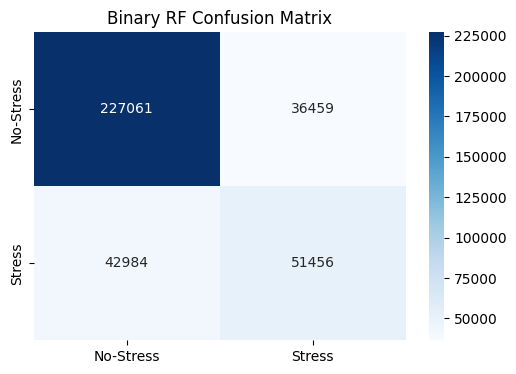

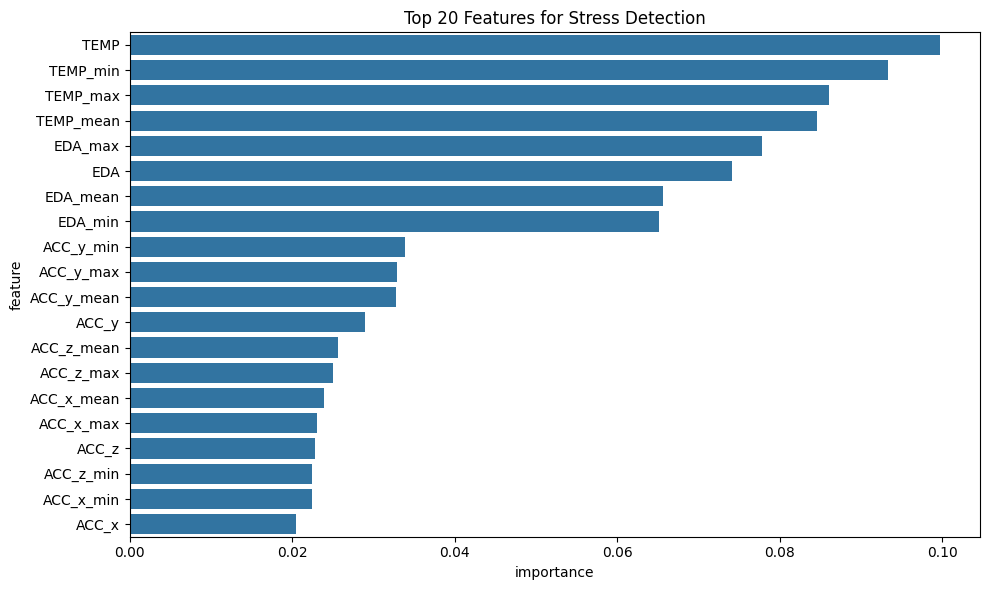

In [0]:
# Binary Class Conversion (Stress vs No-Stress)
# Based on previous analysis, we simplify to binary classification
print("Before binary conversion:", data['labels'].value_counts())

# Convert to binary: Stress (1) vs No-Stress (0=Baseline, 2=Amusement)
data['stress_label'] = data['labels'].apply(lambda x: 1 if x == 1 else 0)  # Stress=1, No-Stress=0
print("\nAfter binary conversion:")
print(data['stress_label'].value_counts())

# Subject-wise Split for Binary Classification
def binary_subject_split(data, test_subjects=['S16', 'S17']):
    """Split data with completely unseen subjects in test set"""
    train_data = data[~data['Subject'].isin(test_subjects)]
    test_data = data[data['Subject'].isin(test_subjects)]

    X_train = train_data[all_features]
    y_train = train_data['stress_label']
    X_test = test_data[all_features]
    y_test = test_data['stress_label']

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = binary_subject_split(data)

# Handle Class Imbalance with SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

print("\nClass distribution before SMOTE:")
print(y_train.value_counts())

# Preprocessing remains same
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features) if cat_features else ('passthrough', 'passthrough', [])
    ])

# Create pipeline with SMOTE
model = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    ))
])

# Train and Evaluate Binary Model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n=== Binary Classification Results ===")
print("Test set class distribution:", y_test.value_counts())
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No-Stress', 'Stress'],
            yticklabels=['No-Stress', 'Stress'])
plt.title('Binary RF Confusion Matrix')
plt.show()

# Feature Importance Analysis
# Get feature names after preprocessing
num_feature_names = num_features
if 'cat' in preprocessor.named_transformers_:
    cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_features)
else:
    cat_feature_names = np.array([])

all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Extract feature importances from pipeline
importances = model.named_steps['classifier'].feature_importances_
feature_imp = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
feature_imp = feature_imp.sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_imp.head(20))
plt.title('Top 20 Features for Stress Detection')
plt.tight_layout()
plt.show()

In [0]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
import os

# ===== DATA LOADING =====
data_path = '/content/drive/Shareddrives/MediCap/Project_files/WESAD/data/WESAD/resampledSensorData.csv'
dataframe = pd.read_excel(excel_path, engine='openpyxl')

# Filter to classes 0,1,2 and convert to binary
data = dataframe[dataframe['labels'].isin([0, 1, 2])].copy()
data['stress_label'] = data['labels'].apply(lambda x: 1 if x == 1 else 0)  # Stress=1, Non-stress=0

# FEATURE ENGINEERING =====
def enhanced_feature_engineering(df, window_size=5, include_magnitude=True):
    """Feature engineering with robust value handling"""
    df = df.copy()

    # Handle infinite/NaN values
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)

    # Clip to physiological ranges
    clip_ranges = {
        'ACC_x': (-15, 15), 'ACC_y': (-15, 15), 'ACC_z': (-15, 15),
        'EDA': (0, 20), 'TEMP': (25, 40), 'BVP': (0, 100)
    }
    for col, (min_val, max_val) in clip_ranges.items():
        if col in df.columns:
            df[col] = df[col].clip(min_val, max_val)

    # Median imputation
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    # Feature engineering
    base_features = ['EDA', 'TEMP', 'BVP', 'ACC_x', 'ACC_y', 'ACC_z']
    new_features = []

    # ACC magnitude
    if include_magnitude:
        df["ACC_magnitude"] = np.sqrt(
            df["ACC_x"]**2 + df["ACC_y"]**2 + df["ACC_z"]**2
        ).clip(0, 25).astype(np.float32)
        base_features.append("ACC_magnitude")

    # Rolling features
    for feature in base_features:
        df[f'{feature}_mean'] = df[feature].rolling(window=window_size, min_periods=1).mean().astype(np.float32)
        df[f'{feature}_std'] = df[feature].rolling(window=window_size, min_periods=1).std().fillna(0).astype(np.float32)
        df[f'{feature}_max'] = df[feature].rolling(window=window_size, min_periods=1).max().astype(np.float32)
        df[f'{feature}_min'] = df[feature].rolling(window=window_size, min_periods=1).min().astype(np.float32)
        df[f'{feature}_diff'] = df[feature].diff().fillna(0).astype(np.float32)
        df[f'{feature}_roc'] = df[feature].pct_change().fillna(0).clip(-1, 1).astype(np.float32)

        new_features.extend([
            f'{feature}_mean', f'{feature}_std',
            f'{feature}_max', f'{feature}_min',
            f'{feature}_diff', f'{feature}_roc'
        ])

    # EDA-TEMP ratio
    if all(col in df.columns for col in ['EDA', 'TEMP']):
        temp_clipped = df['TEMP'].clip(25, 40) + 0.001
        df['EDA_TEMP_ratio'] = (df['EDA'] / temp_clipped).replace([np.inf, -np.inf], np.nan)
        df['EDA_TEMP_ratio'] = df['EDA_TEMP_ratio'].fillna(df['EDA_TEMP_ratio'].median()).astype(np.float32)
        new_features.append('EDA_TEMP_ratio')

    return df, base_features + new_features

# PREPROCESSING
def get_processed_data_binary(self, subject_filter=None):
    """Process data specifically for XGBoost binary classification"""
    # Load and filter data
    df = self.raw_data.copy()
    if subject_filter is not None:drive
        df = df[df['Subject'].isin(subject_filter)]

    # Apply enhanced feature engineering
    df, features = enhanced_feature_engineering(df)

    # Filter to only stress-related labels (1,2,3) then convert to binary
    df = df[df['labels'].isin([1, 2, 3])].copy()
    df['stress_label'] = (df['labels'] == 2).astype(int)  # Stress=1 (label 2), Non-stress=0 (labels 1,3)

    # Prepare final outputs
    X = df[features]
    y = df['stress_label'].values
    groups = df['Subject'].values
    class_names = ['Non-stress', 'Stress']

    return X, y, groups, class_names

# MODEL TRAINING
def train_evaluate_binary(processor, test_subjects=['S16', 'S17']):
    """
    Train and evaluate XGBoost binary classifier with:
    1. Hold-out test set evaluation
    2. LOSO validation on training subjects
    """
    # Get processed data using the new binary preprocessing
    train_subjects = [s for s in processor.raw_data['Subject'].unique()
                     if s not in test_subjects]

    # Hold-out test evaluation
    X_train, y_train, train_groups, class_names = processor.get_processed_data_binary(train_subjects)
    X_test, y_test, _, _ = processor.get_processed_data_binary(test_subjects)

    # Preprocessing pipeline
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), X_train.columns)
    ])

    # Train and evaluate on hold-out set
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=sum(y_train==0)/sum(y_train==1),
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_train_processed, y_train)

    # Hold-out test evaluation
    y_pred = model.predict(X_test_processed)
    print("\n=== Hold-out Test Evaluation ===")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # LOSO Validation
    print("\n=== LOSO Validation ===")
    logo = LeaveOneGroupOut()
    accuracies = []

    # Get full training data for LOSO
    X_loso, y_loso, groups_loso, _ = processor.get_processed_data_binary(train_subjects)
    X_loso = preprocessor.fit_transform(X_loso)  # Refit on full training data

    for train_idx, test_idx in logo.split(X_loso, y_loso, groups=groups_loso):
        subject = groups_loso[test_idx[0]]

        model_loso = xgb.XGBClassifier(
            objective='binary:logistic',
            scale_pos_weight=sum(y_loso[train_idx]==0)/sum(y_loso[train_idx]==1),
            random_state=42
        )
        model_loso.fit(X_loso[train_idx], y_loso[train_idx])

        acc = model_loso.score(X_loso[test_idx], y_loso[test_idx])
        accuracies.append(acc)
        print(f"Subject {subject}: Accuracy = {acc:.3f}")

    print("\n=== LOSO Summary ===")
    print(f"Mean Accuracy: {np.mean(accuracies):.3f}")
    print(f"Std Dev: {np.std(accuracies):.3f}")

    return model

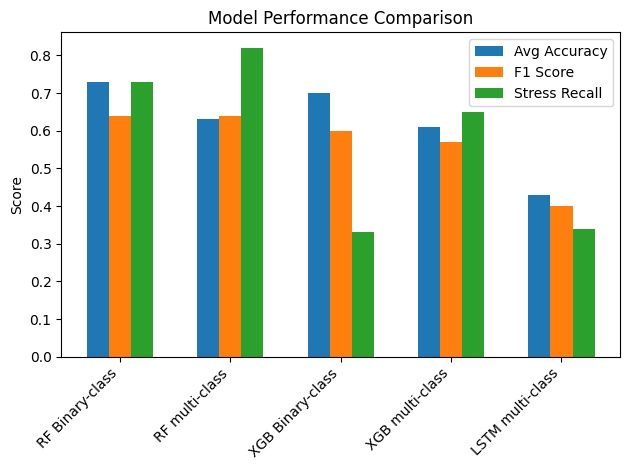

In [0]:
# Load data
models = ['RF Binary-class', 'RF multi-class',  'XGB Binary-class', 'XGB multi-class',   'LSTM multi-class']
acc = [ .73, .63,  .70, .61, .43]
f1 = [.64, .64,  .60, .57, .40]
rec = [.73, .82, .33, .65,  .34]
df = pd.DataFrame({'Model':models, 'Avg Accuracy': acc, 'F1 Score':f1, 'Stress Recall': rec})


models       = df['Model'].values
avg_accuracy = df['Avg Accuracy'].values
f1_scores    = df['F1 Score'].values
stress_recall= df['Stress Recall'].values

# X positions
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots()
ax.bar(x - width, avg_accuracy,   width, label='Avg Accuracy')
ax.bar(x,         f1_scores,      width, label='F1 Score')
ax.bar(x + width, stress_recall,  width, label='Stress Recall')

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend()

plt.tight_layout()
plt.show()
